In [1]:
import os
import sys

import numpy as np
import pandas as pd

import pytorch_lightning as pl
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import textwrap

import gseapy as gp

pl.seed_everything(32)

sys.path.append("/data/danai/scripts/LIVI/")
from src.analysis._utils import select_important_genes_for_factor_IQR
from src.analysis.plotting import cell_state_factors_heatmap, plot_D_factor_corr, plot_DxC_similarity, plot_donor_similarity

Seed set to 32
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 32


In [2]:
adata = sc.read_h5ad("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K.h5ad")
adata

AnnData object with n_obs × n_vars = 1172790 × 14212
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent_mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MITO', 'log1p_total_counts_MITO', 'pct_counts_MITO', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_genes', 'Norm_factors', 'major_celltype', 'predicted_celltype_l0', 'predicted_celltype_l1', 'predicted_celltype_l2', 'original_celltype', 'new_predicted_celltype_l2', 'new_predicted_celltype_l0', 'new_predicted_celltype_l1'
    var: 'GeneSymbol', 'features', 'MITO', 'RIBO', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'downregulated_NK', '

In [3]:
gene_anno = pd.read_csv("/data/danai/Data/OneK1K/OneK1K_HVG-HEX-10K_geneIDs_Biomart.txt", sep="\t", index_col=0)
gene_anno.rename(columns={"Gene stable ID":"feature_id", 
                         "Gene name":"gene_name",
                         "Chromosome/scaffold name":"gene_chromosome", 
                         "Gene start (bp)":"gene_start", 
                         "Gene end (bp)":"gene_end"},
                inplace=True)
gene_anno

gene_start gene_chromosome   gene_end      gene_name
Gene stable ID                                                       
ENSG00000000419    49551404              20   49575092           DPM1
ENSG00000000457   169818772               1  169863408          SCYL3
ENSG00000000460   169631245               1  169823221       C1orf112
ENSG00000000938    27938575               1   27961788            FGR
ENSG00000000971   196621008               1  196716634            CFH
...                     ...             ...        ...            ...
ENSG00000273269    47293080               2   47403650   RP11-761B3.1
ENSG00000273274    32930670               1   32962287         ZBTB8B
ENSG00000273294    33987279               5   34124633  RP11-1084J3.4
ENSG00000273331   196042953               3  196065244        TM4SF19
ENSG00000273398    68358370               2   68488362  RP11-474G23.1

[14212 rows x 4 columns]

In [47]:
adata.var.GeneSymbol = adata.var.GeneSymbol.str.strip()
adata.var = adata.var.merge(gene_anno.filter(["gene_chromosome", "gene_start", "gene_end"]), right_index=True, left_index=True)
adata.var

GeneSymbol  features   MITO   RIBO   ERCC  n_cells_by_counts  \
ENSG00000257019     OR13C2    OR13C2  False  False  False                  3   
ENSG00000166987       MBD6      MBD6  False  False  False              34604   
ENSG00000170624       SGCD      SGCD  False  False  False               1844   
ENSG00000140519       RHCG      RHCG  False  False  False                  2   
ENSG00000117115      PADI2     PADI2  False  False  False               2728   
...                    ...       ...    ...    ...    ...                ...   
ENSG00000185811      IKZF1     IKZF1  False  False  False             338926   
ENSG00000234465     PINLYP    PINLYP  False  False  False               3098   
ENSG00000170615    SLC26A5   SLC26A5  False  False  False                685   
ENSG00000151778      SERP2     SERP2  False  False  False               2513   
ENSG00000188993     LRRC66    LRRC66  False  False  False                116   

                 mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
ENSG00000257019     0.000002           0.000002              99.999764   
ENSG00000166987     0.027840           0.027459              97.280605   
ENSG00000170624     0.001487           0.001486              99.855087   
ENSG00000140519     0.000002           0.000002              99.999843   
ENSG00000117115     0.002279           0.002276              99.785617   
...                      ...                ...                    ...   
ENSG00000185811     0.332737           0.287235              73.365114   
ENSG00000234465     0.002490           0.002487              99.756540   
ENSG00000170615     0.000540           0.000540              99.946168   
ENSG00000151778     0.002013           0.002011              99.802513   
ENSG00000188993     0.000091           0.000091              99.990884   

                 total_counts  ...  downregulated_CD8T  upregulated_B  \
ENSG00000257019           3.0  ...               False          False   
ENSG00000166987       35426.0  ...                True           True   
ENSG00000170624        1892.0  ...               False           True   
ENSG00000140519           2.0  ...               False          False   
ENSG00000117115        2900.0  ...                True           True   
...                       ...  ...                 ...            ...   
ENSG00000185811      423404.0  ...                True           True   
ENSG00000234465        3168.0  ...               False          False   
ENSG00000170615         687.0  ...               False          False   
ENSG00000151778        2561.0  ...                True           True   
ENSG00000188993         116.0  ...               False          False   

                 downregulated_B  upregulated_Mono  downregulated_Mono  \
ENSG00000257019            False             False               False   
ENSG00000166987             True              True               False   
ENSG00000170624             True              True                True   
ENSG00000140519            False             False               False   
ENSG00000117115             True              True               False   
...                          ...               ...                 ...   
ENSG00000185811             True              True                True   
ENSG00000234465            False             False               False   
ENSG00000170615            False             False               False   
ENSG00000151778             True              True                True   
ENSG00000188993            False             False               False   

                 upregulated_DC  downregulated_DC  gene_chromosome  \
ENSG00000257019           False             False                9   
ENSG00000166987           False              True               12   
ENSG00000170624           False              True                5   
ENSG00000140519           False             False               15   
ENSG00000117115            True              True 

In [52]:
background_genes = adata.var.GeneSymbol
# databases_bio = ["GO_Biological_Process_2023", "Elsevier_Pathway_Collection",  "GO_Molecular_Function_2023", "KEGG_2021_Human", "Reactome_2022"] 
databases_bio = ["GO_Biological_Process_2023", "GO_Molecular_Function_2023", "KEGG_2021_Human", "Reactome_2022"] 

In [5]:
results_dir = "/data/danai/Data/OneK1K/LIVI2_testing_results/"
model = "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best"
model_results_dir = os.path.join(results_dir, model)
os.path.isdir(model_results_dir)

True

## Cell-state factors

In [6]:
cell_state = pd.read_csv(os.path.join(model_results_dir, f"{model}_cell-state_latent.tsv"),
                    sep="\t", index_col=0)

In [8]:
cc_softmax = nn.Softmax(dim=1)(torch.from_numpy(cell_state.to_numpy())).numpy()

In [9]:
assignment_matrix = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_factor_assignment_matrix.tsv"),
    sep="\t", index_col=0
)
assignment_matrix.columns = assignment_matrix.columns.str.replace("U_", "D_")
assignment_matrix.head()

D_Factor1     D_Factor2  D_Factor3     D_Factor4  \
Cell-state_Factor1  8.437773e-07  7.903217e-08   0.000149  2.960464e-08   
Cell-state_Factor2  1.292795e-06  6.067657e-08   0.000136  6.915393e-08   
Cell-state_Factor3  9.953613e-07  6.230532e-08   0.000141  1.447328e-06   
Cell-state_Factor4  6.680752e-07  6.124807e-02   0.000136  3.778137e-08   
Cell-state_Factor5  4.728630e-06  2.615931e-08   0.000146  6.789284e-04   

                    D_Factor5     D_Factor6     D_Factor7  D_Factor8  \
Cell-state_Factor1   0.105288  9.999727e-01  5.675518e-07   0.958925   
Cell-state_Factor2   0.105908  1.794856e-02  5.106163e-07   0.115423   
Cell-state_Factor3   0.000004  4.638549e-07  9.892867e-01   0.965989   
Cell-state_Factor4   0.011434  4.063994e-07  9.991040e-01   0.019197   
Cell-state_Factor5   0.123782  2.302163e-07  5.004259e-07   1.000000   

                    D_Factor9  D_Factor10  ...   D_Factor691   D_Factor692  \
Cell-state_Factor1   0.000287    0.000158  ...  5.023212e-06  4.209568e-06   
Cell-state_Factor2   0.026317    0.000138  ...  1.773568e-07  6.894123e-06   
Cell-state_Factor3   0.000585    0.000156  ...  2.023449e-07  2.216382e-06   
Cell-state_Factor4   0.008096    0.000136  ...  2.121831e-07  3.456871e-07   
Cell-state_Factor5   0.305943    0.000152  ...  8.162028e-08  3.348259e-02   

                     D_Factor693   D_Factor694   D_Factor695  D_Factor696  \
Cell-state_Factor1  1.000000e+00  4.168299e-03  9.999992e-01     0.209136   
Cell-state_Factor2  7.097198e-02  2.241115e-07  8.517019e-07     0.047724   
Cell-state_Factor3  5.867200e-05  5.172464e-03  6.707507e-07     0.132809   
Cell-state_Factor4  4.101363e-08  3.866343e-07  6.646220e-07     0.102437   
Cell-state_Factor5  3.075602e-08  2.127417e-07  4.462411e-07     0.080859   

                    D_Factor697   D_Factor698  D_Factor699  D_Factor700  
Cell-state_Factor1     0.078419  6.167789e-07     0.018491     0.140772  
Cell-state_Factor2     0.001983  7.762388e-07     0.000035     0.041986  
Cell-state_Factor3     0.001249  1.094831e-06     0.938939     0.154773  
Cell-state_Factor4     0.012960  7.976132e-07     0.000011     0.032869  
Cell-state_Factor5     0.288426  5.094969e-07     0.029717     0.271452  

[5 rows x 700 columns]

In [10]:
D = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_U_embedding.tsv"),
    sep="\t", index_col=0
)
D.columns = D.columns.str.replace("U_", "D_")
D.head()

D_Factor1  D_Factor2  D_Factor3  D_Factor4  D_Factor5  D_Factor6  \
individual                                                                     
691_692     -1.042473  -3.014132   1.014801   1.139763  -0.087979  -0.651705   
693_694      0.204075  -1.975144  -0.909941  -3.882647  -2.031409  -1.043576   
688_689     -0.265995  -0.624907  -0.622831  -2.176815   0.853737  -0.117719   
683_684      0.416159  -2.862958  -0.515983   1.572177   0.868042  -0.119366   
684_685     -1.244226  -4.169203  -0.287462  -0.519455   3.750650  -1.336222   

            D_Factor7  D_Factor8  D_Factor9  D_Factor10  ...  D_Factor691  \
individual                                               ...                
691_692      0.490216  -0.437837  -0.698968   -0.075018  ...    -1.559727   
693_694     -0.600040   0.700274  -1.798226    1.284830  ...    -4.333742   
688_689      0.055314   0.302469   0.608836   -1.786304  ...    -0.670751   
683_684     -0.109651   0.556453   1.886532   -1.681124  ...    -2.243293   
684_685      0.230874  -0.624908   1.064494    0.636243  ...     0.699778   

            D_Factor692  D_Factor693  D_Factor694  D_Factor695  D_Factor696  \
individual                                                                    
691_692       -2.399024    -0.448335    -0.562907     1.627759     0.417358   
693_694       -0.440545     3.113877    -1.716786    -1.533546     0.933507   
688_689       -1.207303     8.913930    -0.353388    -0.325745    -1.125641   
683_684       -1.778274     0.387456     0.630929    -0.590417     0.165828   
684_685       -3.021685    -0.273128    -0.655736    -0.635290     0.228497   

            D_Factor697  D_Factor698  D_Factor699  D_Factor700  
individual                                                      
691_692       -0.134628     0.011702    -0.679321     0.457391  
693_694        1.020350     0.339764    -1.053410     0.119764  
688_689        0.403694    -0.928585     0.525144    -0.484701  
683_684       -2.937147     0.222008    -0.201923     0.057328  
684_685        1.079147    -1.051518     0.797644     0.003049  

[5 rows x 700 columns]

In [11]:
DxC_decoder = pd.read_csv(os.path.join(model_results_dir,f"{model}_GxC_decoder.tsv"),
                          sep="\t", index_col=0)
DxC_decoder.columns = DxC_decoder.columns.str.replace("GxC", "DxC")
DxC_decoder.head()

DxC_Factor1  DxC_Factor2  DxC_Factor3  DxC_Factor4  \
Geneid                                                                
ENSG00000257019     0.000003    -0.000156     0.000261    -0.000105   
ENSG00000166987    -0.000101    -0.000302     0.000002    -0.000025   
ENSG00000170624    -0.000007    -0.000096    -0.000228     0.000753   
ENSG00000140519     0.000013    -0.000071     0.000062    -0.000007   
ENSG00000117115    -0.000463    -0.000236     0.000113    -0.000527   

                 DxC_Factor5  DxC_Factor6  DxC_Factor7  DxC_Factor8  \
Geneid                                                                
ENSG00000257019     0.000109    -0.000148     0.000145     0.000002   
ENSG00000166987     0.000096    -0.000122     0.000290    -0.000218   
ENSG00000170624    -0.000033    -0.000042    -0.000032     0.001457   
ENSG00000140519    -0.000070     0.000082    -0.000036     0.000126   
ENSG00000117115     0.000036     0.000147    -0.000130    -0.000716   

                 DxC_Factor9  DxC_Factor10  ...  DxC_Factor691  DxC_Factor692  \
Geneid                                      ...                                 
ENSG00000257019     0.000106     -0.000083  ...      -0.000125      -0.000088   
ENSG00000166987    -0.000033      0.000128  ...      -0.000093      -0.000059   
ENSG00000170624     0.000291     -0.000079  ...      -0.000690       0.000181   
ENSG00000140519    -0.000059     -0.000021  ...       0.000164       0.000251   
ENSG00000117115    -0.000064      0.000002  ...       0.000046       0.000210   

                 DxC_Factor693  DxC_Factor694  DxC_Factor695  DxC_Factor696  \
Geneid                                                                        
ENSG00000257019       0.000062      -0.000037      -0.000043      -0.000013   
ENSG00000166987      -0.000712       0.000007      -0.000217       0.000056   
ENSG00000170624      -0.004836       0.000014      -0.000040       0.000021   
ENSG00000140519      -0.000099       0.000035      -0.000080      -0.000019   
ENSG00000117115       0.000123      -0.000185      -0.000235       0.000060   

                 DxC_Factor697  DxC_Factor698  DxC_Factor699  DxC_Factor700  
Geneid                                                                       
ENSG00000257019      -0.000199      -0.000141       0.000042       0.000049  
ENSG00000166987       0.000027       0.000117      -0.000141       0.000014  
ENSG00000170624       0.000080       0.000070      -0.000669      -0.000014  
ENSG00000140519      -0.000139       0.000042      -0.000011      -0.000129  
ENSG00000117115      -0.000145       0.000712      -0.000128      -0.000025  

[5 rows x 700 columns]

In [12]:
GxC_effects = pd.read_csv(
    os.path.join(model_results_dir, f"{os.path.basename(model_results_dir)}_LMM_results_BH-0.05_Ucontext.tsv"),
    sep="\t"
)
GxC_effects.Factor = GxC_effects.Factor.str.replace("U_", "D_")
GxC_effects

Factor       SNP_id  effect_size  effect_size_se       p_value  \
0       D_Factor1  14:81884515     0.128089        0.029964  1.747683e-05   
1       D_Factor5  19:58963530     0.585091        0.071890  1.218412e-16   
2      D_Factor11  6:161111700     1.012741        0.201583  4.265749e-07   
3      D_Factor12   3:39555580     0.505091        0.055674  1.831975e-20   
4      D_Factor14  2:232579379    -0.201663        0.025578  1.112895e-15   
...           ...          ...          ...             ...           ...   
3989  D_Factor696   6:35402805     2.013616        0.270934  4.697587e-14   
3990  D_Factor698  22:37918472     0.315602        0.064524  8.591598e-07   
3991  D_Factor698  22:38175477     0.298677        0.057110  1.387957e-07   
3992  D_Factor700  2:102957291    -0.758697        0.154228  7.418975e-07   
3993  D_Factor700   6:33395199     0.281587        0.052397  6.152421e-08   

     assessed_allele  corrected_pvalue  
0                  G      3.124271e-02  
1                  G      8.928493e-13  
2                  C      1.083497e-03  
3                  A      1.759641e-16  
4                  G      7.537058e-12  
...              ...               ...  
3989               C      2.723306e-10  
3990               T      2.062331e-03  
3991               T      3.829152e-04  
3992               A      1.806789e-03  
3993               G      1.800964e-04  

[3994 rows x 7 columns]

In [13]:
GxC_effects.SNP_id.nunique()

941

In [14]:
sign_factors = GxC_effects.Factor.unique().tolist()

## D/DxC Factors

### Different cell-states are characterised by different regulatory programmes

In [16]:
DxC = pd.DataFrame(
    (cc_softmax @ assignment_matrix.filter(GxC_effects.Factor.unique()).to_numpy())  * D.filter(GxC_effects.Factor.unique()).loc[adata.obs["individual"]].to_numpy(),
    index=cell_state.index, columns=assignment_matrix.filter(GxC_effects.Factor.unique()).columns
)
DxC.columns = [c.replace("D_", "DxC ") for c in DxC.columns]
DxC

DxC Factor1  DxC Factor5  DxC Factor11  DxC Factor12  \
barcode                                                                    
AAACCTGAGAATGTTG-1    -0.144587    -0.006275      0.101098     -0.121403   
AAACCTGAGAGAACAG-1     0.041220    -0.142875      0.066472     -0.148095   
AAACCTGAGCATGGCA-1    -0.037570     0.045440      0.084652     -0.137933   
AAACCTGAGTATTGGA-1     0.062550     0.056118      0.200590     -0.047997   
AAACCTGAGTGTCCCG-1    -0.193813     0.247543      0.022720      0.012648   
...                         ...          ...           ...           ...   
TTTGTCATCCGCTGTT-9    -0.135961     0.040589     -0.008268     -0.005956   
TTTGTCATCCGTTGTC-9     0.017443     0.103983      0.024371     -0.080515   
TTTGTCATCGCCGTGA-9     0.099838    -0.067820      0.042792     -0.198917   
TTTGTCATCGCGGATC-9    -0.158064     0.104002      0.006299     -0.025327   
TTTGTCATCTCGTATT-9     0.237052    -0.071946      0.075349     -0.211651   

                    DxC Factor14  DxC Factor18  DxC Factor19  DxC Factor21  \
barcode                                                                      
AAACCTGAGAATGTTG-1     -0.135596      0.025357      0.008575      0.034477   
AAACCTGAGAGAACAG-1     -0.120640     -0.040403      0.071250      0.040388   
AAACCTGAGCATGGCA-1     -0.013302      0.040735      0.127284      0.084567   
AAACCTGAGTATTGGA-1      0.133443      0.077024      0.002577     -0.007443   
AAACCTGAGTGTCCCG-1     -0.000521     -0.028395     -0.045483      0.013713   
...                          ...           ...           ...           ...   
TTTGTCATCCGCTGTT-9     -0.027606     -0.048250      0.141493      0.004583   
TTTGTCATCCGTTGTC-9     -0.101157      0.018097      0.131757     -0.084197   
TTTGTCATCGCCGTGA-9      0.416393     -0.024929     -0.051441      0.166310   
TTTGTCATCGCGGATC-9      0.076358      0.012983      0.016568     -0.004361   
TTTGTCATCTCGTATT-9      0.602693     -0.076093     -0.034083      0.013677   

                    DxC Factor22  DxC Factor25  ...  DxC Factor685  \
barcode                                         ...                  
AAACCTGAGAATGTTG-1     -0.211030      0.140816  ...       0.061056   
AAACCTGAGAGAACAG-1      0.086799     -0.750067  ...       0.020724   
AAACCTGAGCATGGCA-1     -0.143136      0.089959  ...       0.054574   
AAACCTGAGTATTGGA-1     -0.192760      0.323221  ...       0.141098   
AAACCTGAGTGTCCCG-1     -0.141557     -0.050349  ...       0.198068   
...                          ...           ...  ...            ...   
TTTGTCATCCGCTGTT-9      0.003520     -0.000456  ...       0.047715   
TTTGTCATCCGTTGTC-9      0.058549      0.061318  ...       0.036162   
TTTGTCATCGCCGTGA-9     -0.068291      0.004664  ...      -0.031391   
TTTGTCATCGCGGATC-9     -0.128660     -0.078422  ...       0.040354   
TTTGTCATCTCGTATT-9     -0.127892      0.007755  ...      -0.080954   

                    DxC Factor686  DxC Factor687  DxC Factor690  \
barcode                                                           
AAACCTGAGAATGTTG-1       0.078836      -0.000666       0.136957   
AAACCTGAGAGAACAG-1       0.031790       0.107109       0.218898   
AAACCTGAGCATGGCA-1      -0.025047       0.022168       0.051776   
AAACCTGAGTATTGGA-1      -0.132308       0.031039      -0.057054   
AAACCTGAGTGTCCCG-1      -0.056021       0.112530      -0.027947   
...                           ...            ...            ...   
TTTGTCATCCGCTGTT-9      -0.056019       0.036745      -0.024520   
TTTGTCATCCGTTGTC-9      -0.111695       0.007212      -0.015816   
TTTGTCATCGCCGTGA-9      -0.067603       0.050368      -0.007338   
TTTGTCATCGCGGATC-9       0.003714       0.017429       0.054392   
TTTGTCATCTCGTATT-9      -0.109009       0.028841      -0.007546   

                    DxC Factor691  DxC Factor692  DxC Factor693  \
barcode                                                           
AAACCTGAGAATGTTG-1      -0.044601      -0.533151      -0.026179   
AAACCTGAGAGAACAG-1      -1.36455

In [17]:
DxC = DxC.merge(adata.obs["cell_label"], right_index=True, left_index=True)
DxC = DxC.groupby("cell_label", observed=True).apply(lambda x: x.mean())
DxC.head()

DxC Factor1  DxC Factor5  DxC Factor11  DxC Factor12  \
cell_label                                                         
B IN          -0.004212     0.006907      0.017481      0.003064   
B Mem         -0.005801     0.006093      0.015137      0.002935   
CD4 ET        -0.006611     0.008188      0.035152     -0.004853   
CD4 NC        -0.006913     0.006110      0.036653     -0.006793   
CD4 SOX4      -0.001401     0.008759      0.027522     -0.007352   

            DxC Factor14  DxC Factor18  DxC Factor19  DxC Factor21  \
cell_label                                                           
B IN            0.111302     -0.026065      0.024135      0.005912   
B Mem           0.100048     -0.030213      0.029531      0.005154   
CD4 ET          0.057996     -0.026803      0.006235      0.004439   
CD4 NC          0.065716     -0.027891      0.007454      0.004173   
CD4 SOX4        0.057109     -0.029035      0.009885     -0.004864   

            DxC Factor22  DxC Factor25  ...  DxC Factor685  DxC Factor686  \
cell_label                              ...                                 
B IN           -0.040379      0.055936  ...       0.010761      -0.015642   
B Mem          -0.029466      0.042905  ...       0.006444      -0.016692   
CD4 ET         -0.054321      0.058589  ...       0.012579      -0.020658   
CD4 NC         -0.046286      0.056774  ...       0.013287      -0.019896   
CD4 SOX4       -0.034077      0.060252  ...       0.007016      -0.020635   

            DxC Factor687  DxC Factor690  DxC Factor691  DxC Factor692  \
cell_label                                                               
B IN             0.000926      -0.004367       0.017503      -0.022628   
B Mem            0.000865      -0.003405       0.011793      -0.023276   
CD4 ET          -0.001522      -0.003740       0.008711      -0.041769   
CD4 NC          -0.000276      -0.003389       0.013106      -0.055118   
CD4 SOX4        -0.000335      -0.003747       0.009343      -0.060190   

            DxC Factor693  DxC Factor696  DxC Factor698  DxC Factor700  
cell_label                                                              
B IN            -0.024440       0.013838       0.009413      -0.000673  
B Mem           -0.045047       0.010380       0.011980       0.004765  
CD4 ET          -0.036615       0.016225       0.008504       0.001685  
CD4 NC          -0.037420       0.016492       0.008775       0.001229  
CD4 SOX4        -0.021374       0.014363       0.010373      -0.000960  

[5 rows x 323 columns]

In [18]:
plot_DxC_similarity(
    D=D,
    associated_factors=GxC_effects.Factor.unique().tolist(),
    A=assignment_matrix,
    cell_state_factors=cell_state,
    cell_metadata=adata.obs,
    celltype_column="cell_label",
    donor_column="individual",
    savefig=os.path.join(model_results_dir, "Figures", model),
    format="png",
)

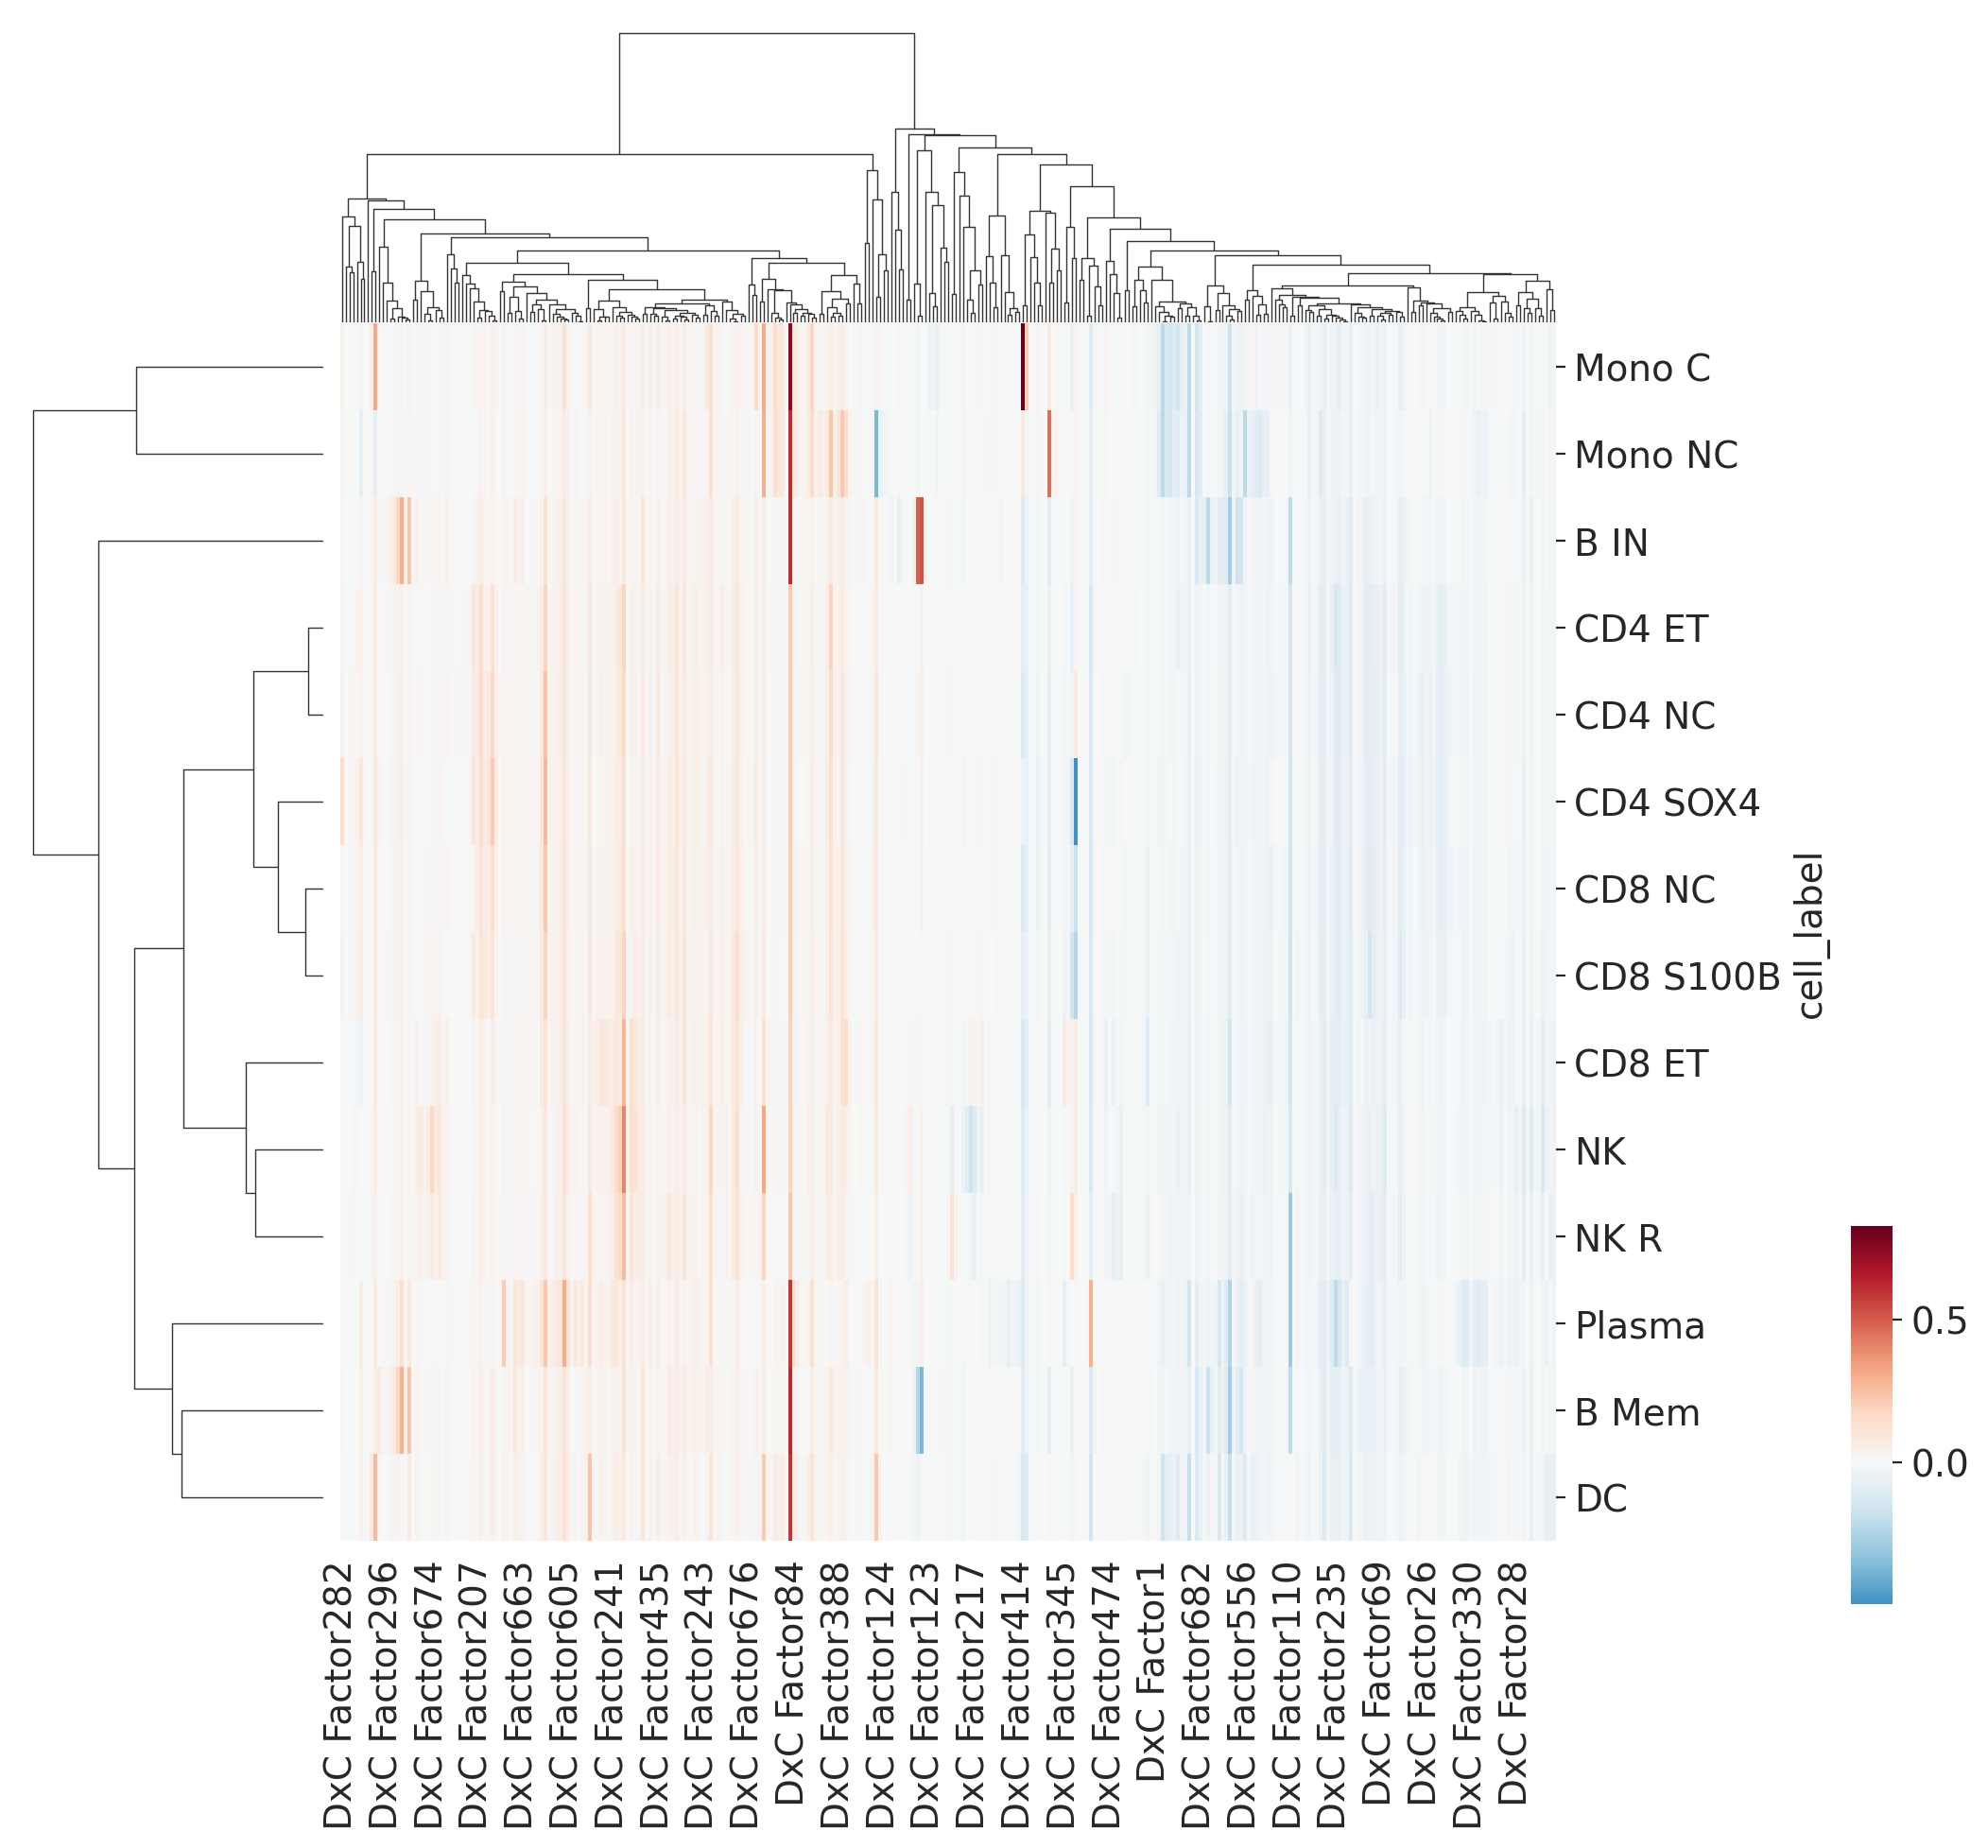

In [23]:
clm = sns.clustermap(
    DxC,
    col_cluster=True,
    row_cluster=True,
    metric="cosine",
    cmap="RdBu_r",
    cbar_pos=(0.99, 0.14, 0.022, 0.2),
    center=0,
    rasterized=True,
)

In [24]:
DxC_plot = DxC.copy()
DxC_plot.columns = DxC_plot.columns.str.replace(" Factor", "")

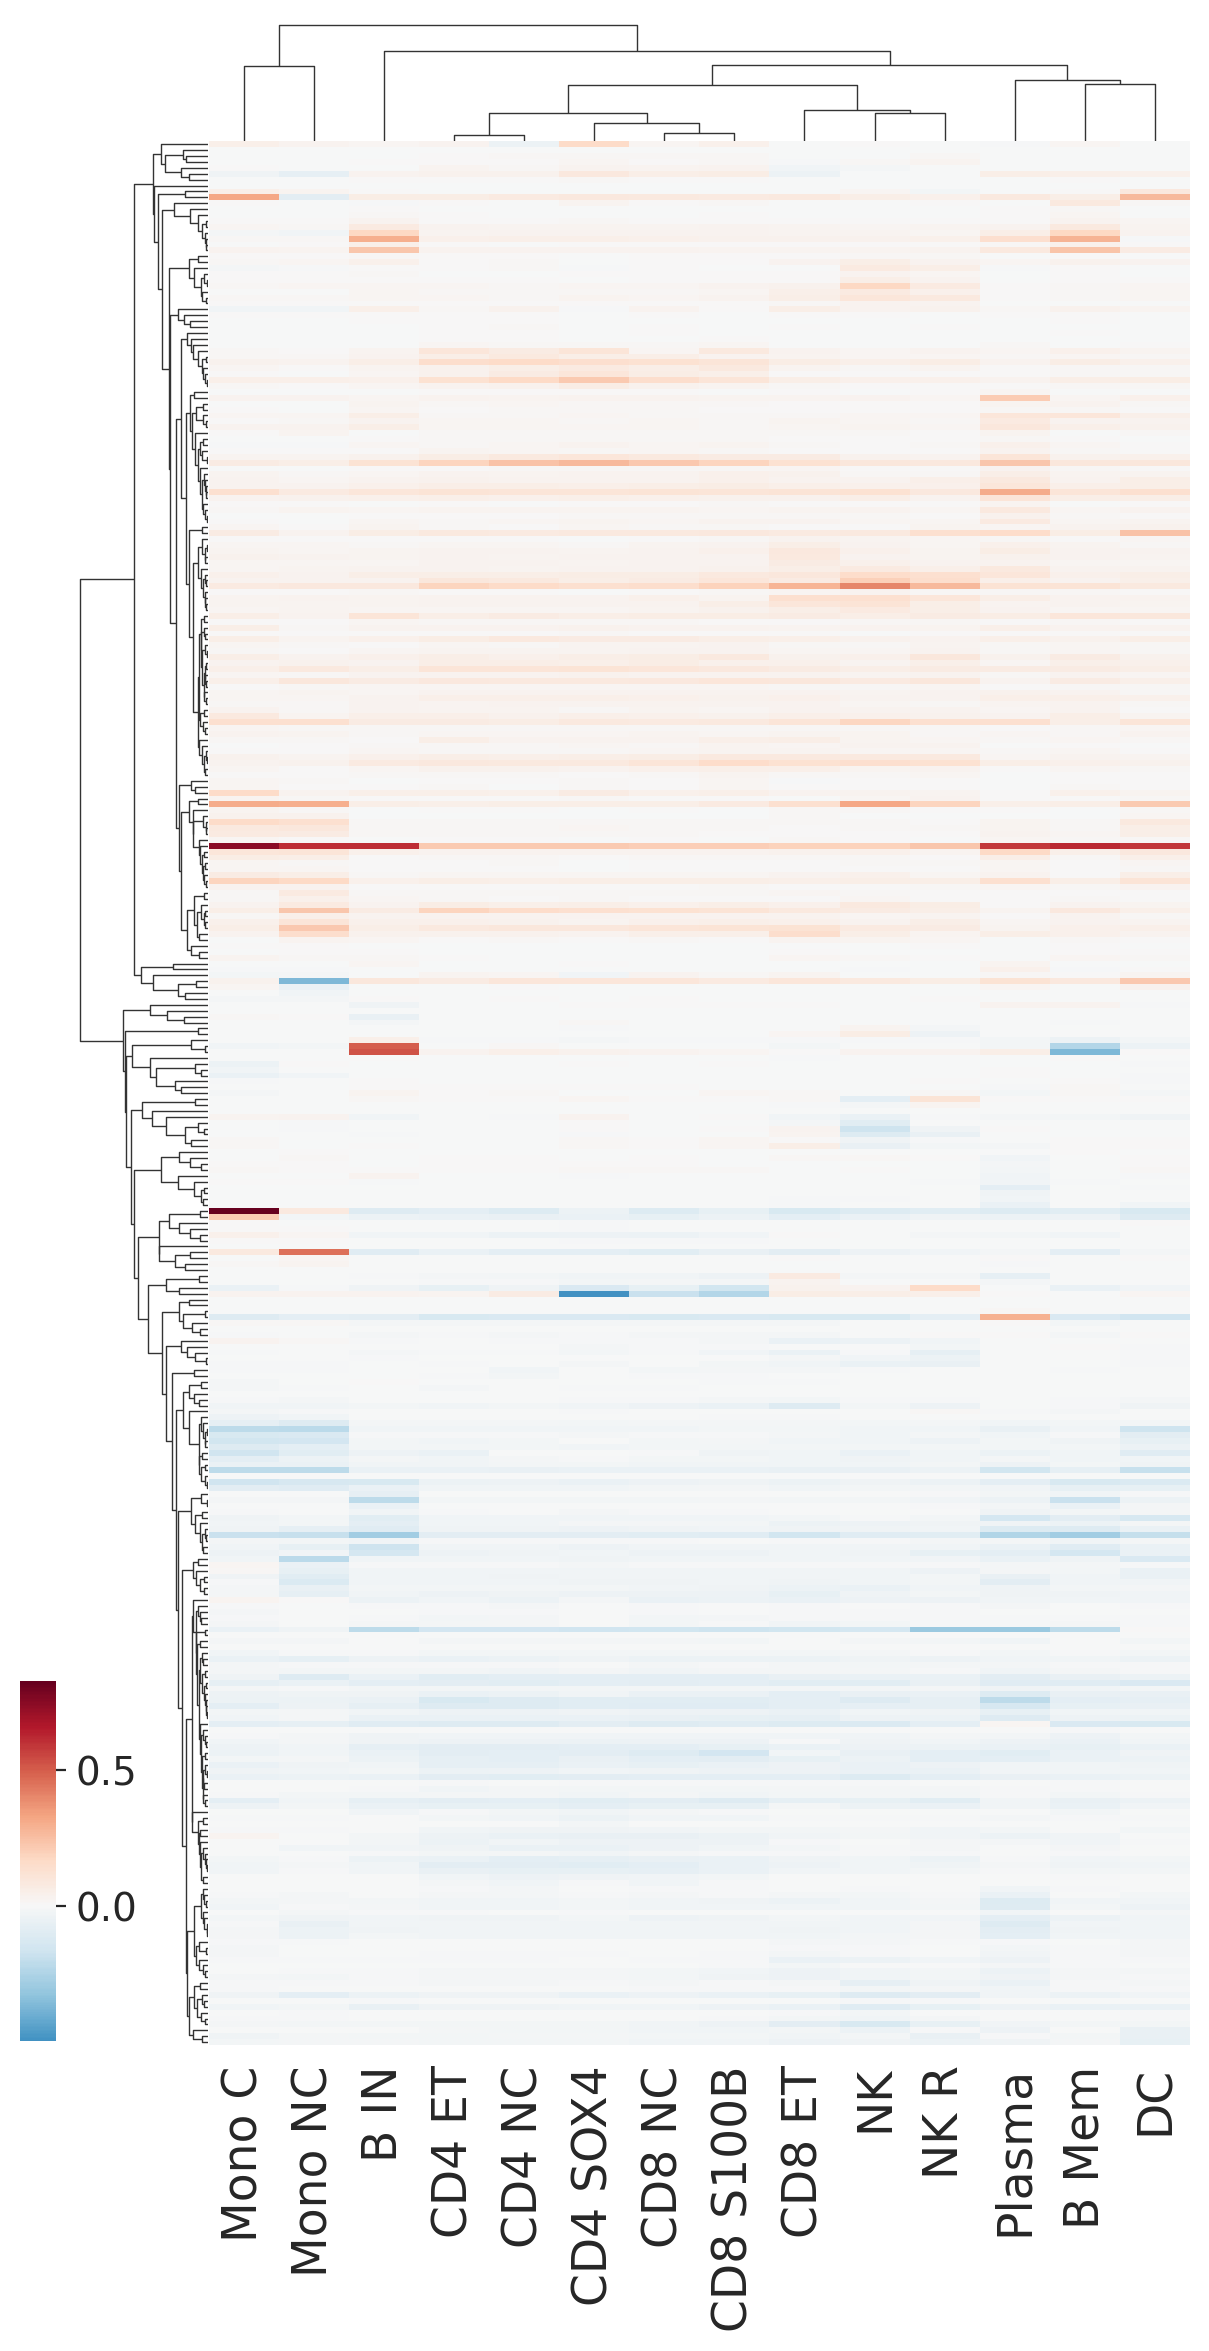

In [32]:
clm = sns.clustermap(
    DxC_plot.T,
    col_cluster=True,
    row_cluster=True,
    figsize=(6,12),
    dendrogram_ratio=(0.12, 0.06),
    metric="cosine",
    cmap="RdBu_r",
    cbar_pos=(-0.01, 0.14, 0.03, 0.15), # (1.01, 0.15, 0.03, 0.16),
    center=0,
    rasterized=True,
    yticklabels=False,
)

clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_xticklabels(
    clm.ax_heatmap.get_xticklabels(),
    fontsize=17
)
# clm.ax_heatmap.set_yticklabels(
#     [uf.get_text().replace("U_", "GxC ") for uf in clm.ax_heatmap.get_yticklabels()],
#     fontsize=15
# )

clm.savefig(
    os.path.join(model_results_dir, "Figures", f"{model}_significant-GxC-factor_and_celltype_cosine_clustering_wo-y-labels.png"),
    dpi=400,
    transparent=True,
    bbox_inches="tight",
)


clm.savefig(
    os.path.join(model_results_dir, "Figures", f"{model}_significant-GxC-factor_and_celltype_cosine_clustering_wo-y-labels.eps"),
    dpi=400,
    transparent=True,
    bbox_inches="tight",
)

clm.savefig(
    os.path.join(model_results_dir, "Figures", f"{model}_significant-GxC-factor_and_celltype_cosine_clustering_wo-y-labels.pdf"),
    dpi=400,
    transparent=True,
    bbox_inches="tight",
)

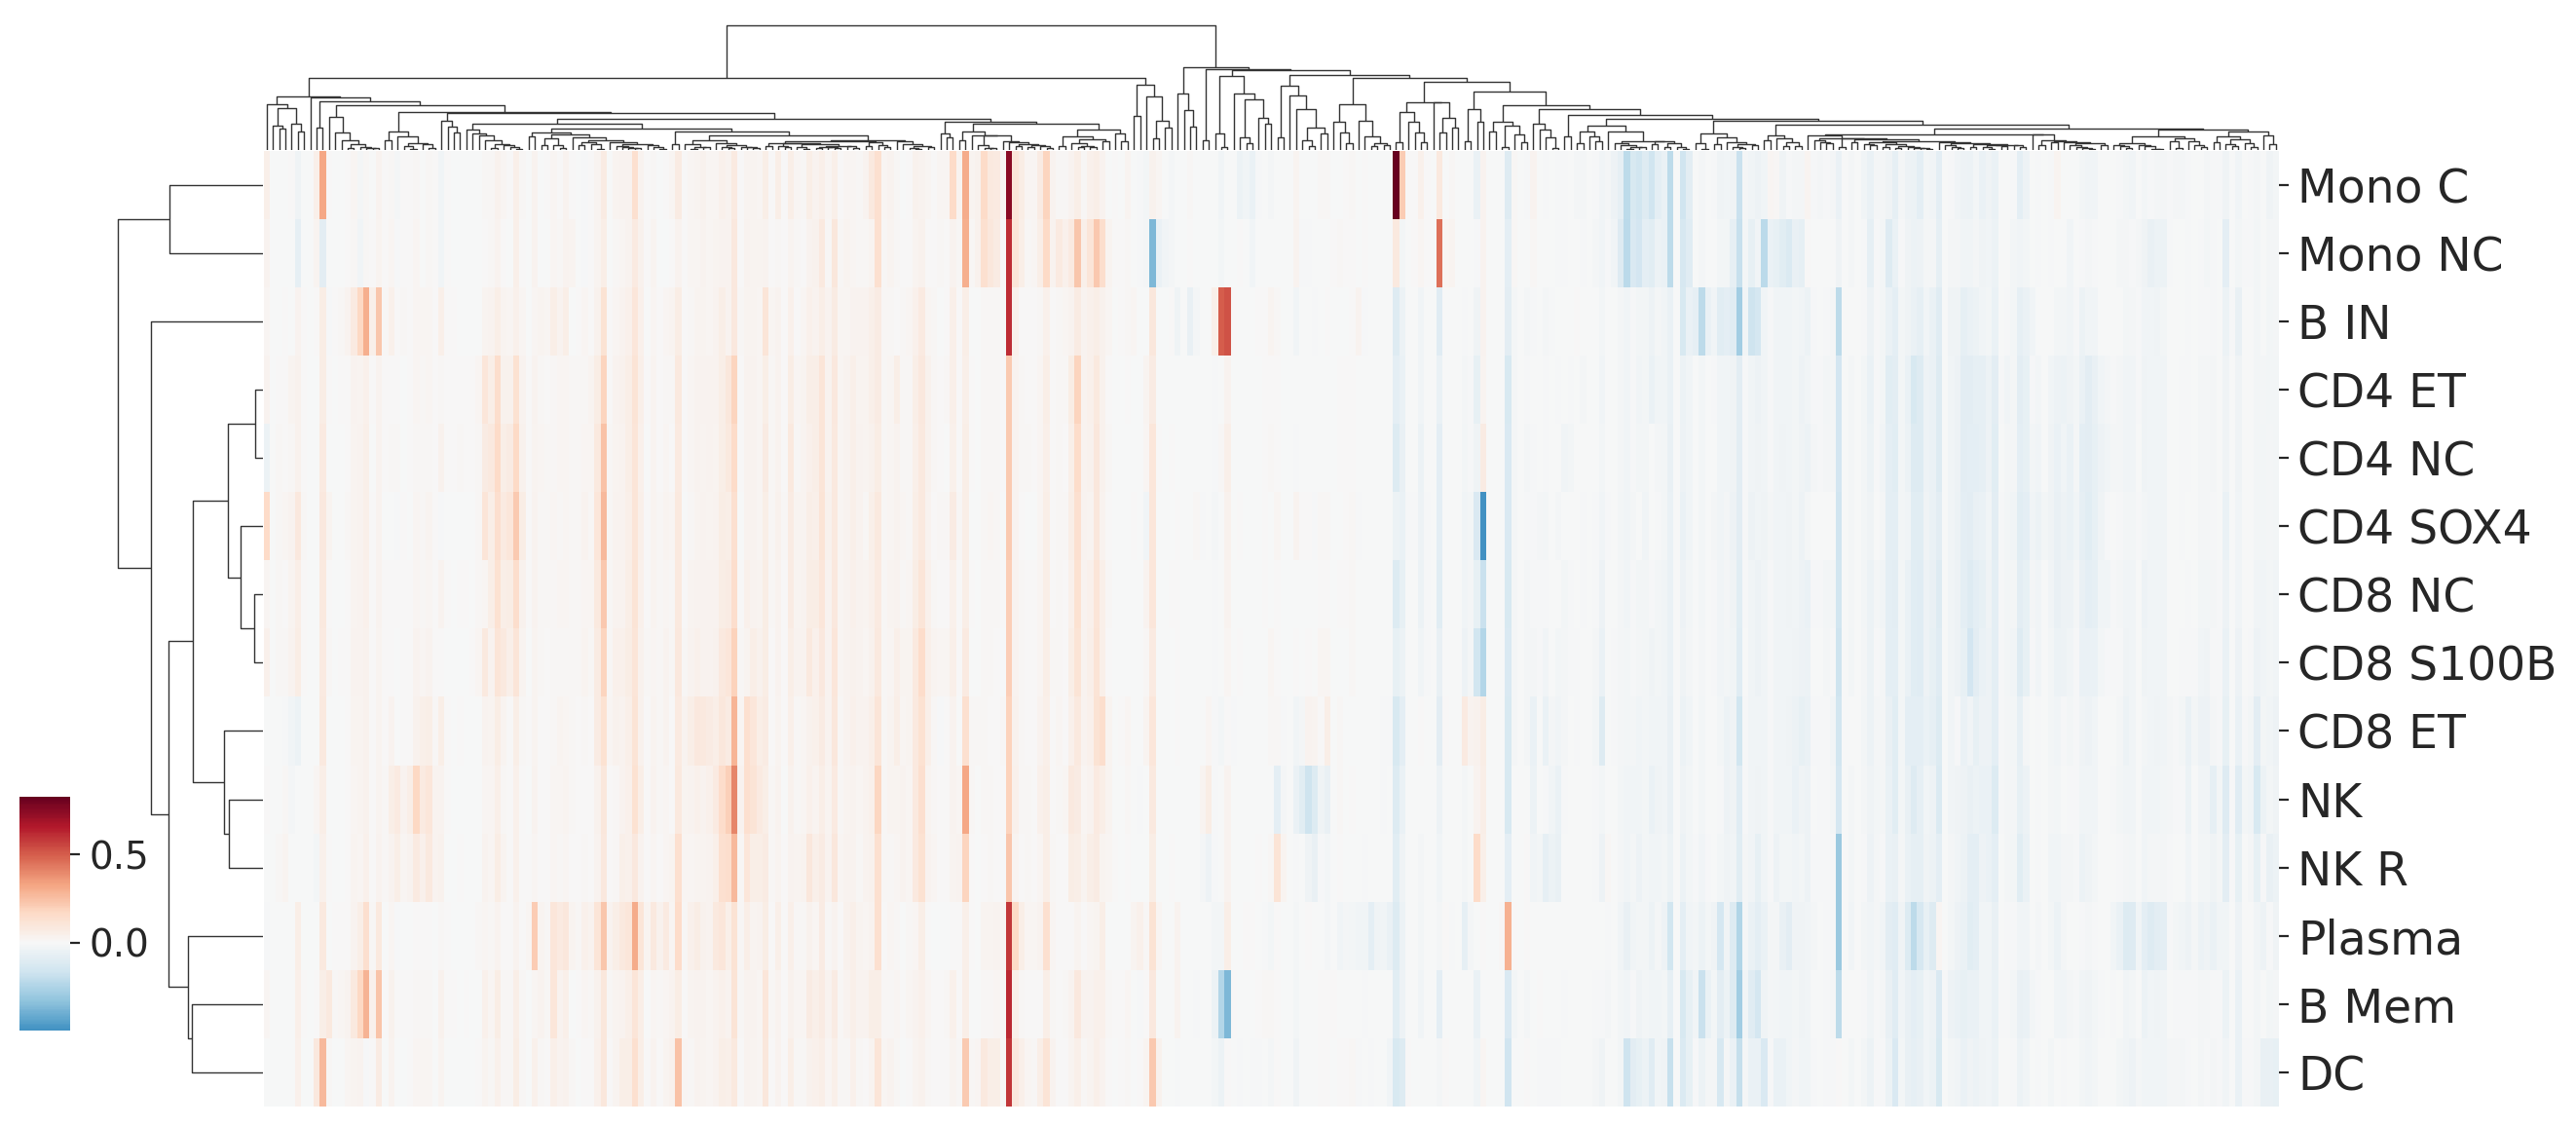

In [42]:
clm = sns.clustermap(
    DxC_plot,
    col_cluster=True,
    row_cluster=True,
    figsize=(13,6),
    dendrogram_ratio=(0.07, 0.12),
    metric="cosine",
    cmap="RdBu_r",
    cbar_pos=(-0.02, 0.1, 0.02, 0.2), # (1.01, 0.15, 0.03, 0.16),
    center=0,
    rasterized=True,
    xticklabels=False,
)

clm.ax_heatmap.set_ylabel("")
clm.ax_heatmap.set_yticklabels(
    clm.ax_heatmap.get_yticklabels(),
    fontsize=17
)

clm.savefig(
    os.path.join(model_results_dir, "Figures", f"{model}_significant-GxC-factor_and_celltype_cosine_clustering_wo-y-labels_transposed.png"),
    dpi=400,
    transparent=True,
    bbox_inches="tight",
)


clm.savefig(
    os.path.join(model_results_dir, "Figures", f"{model}_significant-GxC-factor_and_celltype_cosine_clustering_wo-y-labels_transposed.eps"),
    dpi=400,
    transparent=True,
    bbox_inches="tight",
)

clm.savefig(
    os.path.join(model_results_dir, "Figures", f"{model}_significant-GxC-factor_and_celltype_cosine_clustering_wo-y-labels_transposed.pdf"),
    dpi=400,
    transparent=True,
    bbox_inches="tight",
)

### Annotate D factors based on GSEA

### Find top genes per factor

In [53]:
factors = []
topgenes = []

for fa in GxC_effects.Factor.unique():
    tgenes = select_important_genes_for_factor_IQR(
        genes_factors_loadings=DxC_decoder.to_numpy(),
        factor_idx=int(fa.replace("D_Factor", ""))-1,
        gene_names=adata.var.loc[DxC_decoder.index].GeneSymbol,
        direction="both",
        threshold = 100,
        plot = False,
    )
    factors.append(fa.replace("D", "DxC"))
    topgenes.append(tgenes)


/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [54]:
factors_topgenes = dict(zip(factors, topgenes))
len(factors_topgenes)

323

In [55]:
len(factors_topgenes["DxC_Factor232"])

17

In [57]:
len(factors_topgenes["DxC_Factor693"])

28

In [58]:
D_pathways_genes_gsea = []

for k,v in factors_topgenes.items():
    try:
        enr_bio = gp.enrichr(
            gene_list=adata.var.loc[DxC_decoder[k].abs().nlargest(len(v)).index]["GeneSymbol"].tolist(),
            gene_sets=databases_bio,
            background=background_genes,
            outdir=None,
        )
        enr_bio_sign = enr_bio.results.loc[enr_bio.results["Adjusted P-value"] < 0.05]
        if enr_bio_sign.shape[0] > 0:
            enr_bio_sign = enr_bio_sign.filter(["Gene_set", "Term", "Genes", "P-value", "Adjusted P-value", "Odds Ratio"])
            enr_bio_sign = enr_bio_sign.assign(Factor = [k]* enr_bio_sign.shape[0])
            D_pathways_genes_gsea.append(enr_bio_sign)
            
    except (ValueError, TypeError):
        print(k)
        continue

/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will 

DxC_Factor103


/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


DxC_Factor118


/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will 

DxC_Factor342


/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will 

DxC_Factor664


/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/enrichr.py:646: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will 

In [59]:
D_pathways_genes_gsea = pd.concat([df.reset_index() for df in D_pathways_genes_gsea], axis=0, ignore_index=True)
D_pathways_genes_gsea.head()

index                    Gene_set  \
0      0  GO_Biological_Process_2023   
1      1  GO_Biological_Process_2023   
2      2  GO_Biological_Process_2023   
3      3  GO_Biological_Process_2023   
4      4  GO_Biological_Process_2023   

                                                Term Genes   P-value  \
0  Intracellular Sequestering Of Iron Ion (GO:000...   FTL  0.000634   
1  Regulation Of Natural Killer Cell Chemotaxis (...  CCL4  0.001268   
2  Positive Regulation Of Calcium-Mediated Signal...  CCL4  0.001690   
3  Negative Regulation By Host Of Viral Transcrip...  CCL4  0.002112   
4  Positive Regulation Of Lymphocyte Chemotaxis (...  CCL4  0.003167   

   Adjusted P-value   Odds Ratio       Factor  
0          0.022945  3547.250000  DxC_Factor1  
1          0.022945  1418.600000  DxC_Factor1  
2          0.022945  1013.142857  DxC_Factor1  
3          0.022945   787.888889  DxC_Factor1  
4          0.022945   506.321429  DxC_Factor1

In [60]:
D_pathways_genes_gsea.drop(columns=["index"], inplace=True)

In [61]:
D_pathways_genes_gsea.rename(columns={"Term":"Pathway"}, inplace=True)

In [62]:
D_pathways_genes_gsea = D_pathways_genes_gsea[["Factor", "Pathway", "Genes", "P-value", "Adjusted P-value", "Odds Ratio", "Gene_set"]]
D_pathways_genes_gsea.head()

Factor                                            Pathway Genes  \
0  DxC_Factor1  Intracellular Sequestering Of Iron Ion (GO:000...   FTL   
1  DxC_Factor1  Regulation Of Natural Killer Cell Chemotaxis (...  CCL4   
2  DxC_Factor1  Positive Regulation Of Calcium-Mediated Signal...  CCL4   
3  DxC_Factor1  Negative Regulation By Host Of Viral Transcrip...  CCL4   
4  DxC_Factor1  Positive Regulation Of Lymphocyte Chemotaxis (...  CCL4   

    P-value  Adjusted P-value   Odds Ratio                    Gene_set  
0  0.000634          0.022945  3547.250000  GO_Biological_Process_2023  
1  0.001268          0.022945  1418.600000  GO_Biological_Process_2023  
2  0.001690          0.022945  1013.142857  GO_Biological_Process_2023  
3  0.002112          0.022945   787.888889  GO_Biological_Process_2023  
4  0.003167          0.022945   506.321429  GO_Biological_Process_2023

In [ ]:
# D_pathways_genes_gsea.to_csv(
#     os.path.join(model_results_dir, "Significant-DxC-factors_GSEA-TopGenes-only-100-IQR-cutoff_all-databases.tsv"), 
#     sep="\t", header=True, index=False)

In [ ]:
D_pathways_genes_gsea = pd.read_csv(os.path.join(model_results_dir, "Significant-DxC-factors_GSEA-TopGenes-only-100-IQR-cutoff_all-databases.tsv"),
                                    sep="\t", index_col=False)

D_pathways_genes_gsea

Factor                                            Pathway  \
0        DxC_Factor1  Intracellular Sequestering Of Iron Ion (GO:000...   
1        DxC_Factor1  Regulation Of Natural Killer Cell Chemotaxis (...   
2        DxC_Factor1  Positive Regulation Of Calcium-Mediated Signal...   
3        DxC_Factor1  Negative Regulation By Host Of Viral Transcrip...   
4        DxC_Factor1  Positive Regulation Of Lymphocyte Chemotaxis (...   
...              ...                                                ...   
21527  DxC_Factor700    Macromolecule Biosynthetic Process (GO:0009059)   
21528  DxC_Factor700                           Translation (GO:0006412)   
21529  DxC_Factor700                       Gene Expression (GO:0010467)   
21530  DxC_Factor700                                           Ribosome   
21531  DxC_Factor700                                Coronavirus disease   

       Genes   P-value  Adjusted P-value   Odds Ratio  \
0        FTL  0.000634          0.022945  3547.250000   
1       CCL4  0.001268          0.022945  1418.600000   
2       CCL4  0.001690          0.022945  1013.142857   
3       CCL4  0.002112          0.022945   787.888889   
4       CCL4  0.003167          0.022945   506.321429   
...      ...       ...               ...          ...   
21527  RPS18  0.011625          0.018582          inf   
21528  RPS18  0.014865          0.018582          inf   
21529  RPS18  0.019515          0.019515          inf   
21530  RPS18  0.009229          0.013315          inf   
21531  RPS18  0.013315          0.013315          inf   

                         Gene_set  
0      GO_Biological_Process_2023  
1      GO_Biological_Process_2023  
2      GO_Biological_Process_2023  
3      GO_Biological_Process_2023  
4      GO_Biological_Process_2023  
...                           ...  
21527  GO_Biological_Process_2023  
21528  GO_Biological_Process_2023  
21529  GO_Biological_Process_2023  
21530             KEGG_2021_Human  
21531             KEGG_2021_Human  

[21532 rows x 7 columns]

In [ ]:
# D_pathways_genes_gsea.loc[D_pathways_genes_gsea.Gene_set == "GO_Biological_Process_2023"].to_csv(
#     os.path.join(model_results_dir, "Significant-DxC-factors_GSEA-TopGenes-only-100-IQR-cutoff_GO-Bio.tsv"), 
#     sep="\t", header=True, index=False)

In [ ]:
# D_pathways_genes_gsea.loc[D_pathways_genes_gsea.Gene_set == "GO_Molecular_Function_2023"].to_csv(
#     os.path.join(model_results_dir, "Significant-DxC-factors_GSEA-TopGenes-only-100-IQR-cutoff_GO-MolFun.tsv"), 
#     sep="\t", header=True, index=False)

In [ ]:
# D_pathways_genes_gsea.loc[D_pathways_genes_gsea.Gene_set == "KEGG_2021_Human"].to_csv(
#     os.path.join(model_results_dir, "Significant-DxC-factors_GSEA-TopGenes-only-100-IQR-cutoff_KEGG.tsv"), 
#     sep="\t", header=True, index=False)

In [ ]:
# D_pathways_genes_gsea.loc[D_pathways_genes_gsea.Gene_set == "Reactome_2022"].to_csv(
#     os.path.join(model_results_dir, "Significant-DxC-factors_GSEA-TopGenes-only-100-IQR-cutoff_Reactome.tsv"), 
#     sep="\t", header=True, index=False)

In [63]:
D_pathways_genes_gsea.groupby("Gene_set").apply(lambda x: x.size, include_groups=False)

Gene_set
GO_Biological_Process_2023    65658
GO_Molecular_Function_2023     7872
KEGG_2021_Human               14226
Reactome_2022                 41436
dtype: int64

In [64]:
### For each DB and Factor select the term supported by the most genes;
# if more than one terms are supported byt the same number of genes, choose the one with the smallest adj.p-value
D_pathways_genes_gsea = D_pathways_genes_gsea.assign(gene_list = D_pathways_genes_gsea.Genes.str.split(";"))
D_pathways_genes_gsea = D_pathways_genes_gsea.assign(n_genes = D_pathways_genes_gsea.apply(lambda x: len(x.gene_list), axis=1))
D_pathways_genes_gsea.head()

Factor                                            Pathway Genes  \
0  DxC_Factor1  Intracellular Sequestering Of Iron Ion (GO:000...   FTL   
1  DxC_Factor1  Regulation Of Natural Killer Cell Chemotaxis (...  CCL4   
2  DxC_Factor1  Positive Regulation Of Calcium-Mediated Signal...  CCL4   
3  DxC_Factor1  Negative Regulation By Host Of Viral Transcrip...  CCL4   
4  DxC_Factor1  Positive Regulation Of Lymphocyte Chemotaxis (...  CCL4   

    P-value  Adjusted P-value   Odds Ratio                    Gene_set  \
0  0.000634          0.022945  3547.250000  GO_Biological_Process_2023   
1  0.001268          0.022945  1418.600000  GO_Biological_Process_2023   
2  0.001690          0.022945  1013.142857  GO_Biological_Process_2023   
3  0.002112          0.022945   787.888889  GO_Biological_Process_2023   
4  0.003167          0.022945   506.321429  GO_Biological_Process_2023   

  gene_list  n_genes  
0     [FTL]        1  
1    [CCL4]        1  
2    [CCL4]        1  
3    [CCL4]        1  
4    [CCL4]        1

In [65]:
D_pathways_genes_gsea = D_pathways_genes_gsea.assign(
    Factor_Pathway = D_pathways_genes_gsea.Factor.str.replace("_Factor", "") + "; " + D_pathways_genes_gsea.Pathway
)

In [66]:
max_n_genes = D_pathways_genes_gsea.groupby(["Factor", "Gene_set"]).apply(lambda x: x.n_genes.max()).rename("max_n_genes")
max_n_genes

/tmp/ipykernel_1813309/1829577691.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Factor         Gene_set                  
DxC_Factor1    GO_Biological_Process_2023    1
               GO_Molecular_Function_2023    1
               KEGG_2021_Human               1
DxC_Factor101  GO_Biological_Process_2023    1
               KEGG_2021_Human               1
                                            ..
DxC_Factor96   GO_Molecular_Function_2023    1
               Reactome_2022                 3
DxC_Factor98   GO_Biological_Process_2023    1
               GO_Molecular_Function_2023    1
               Reactome_2022                 1
Name: max_n_genes, Length: 993, dtype: int64

In [67]:
max_n_genes = max_n_genes.reset_index(drop=False)
max_n_genes.head()

Factor                    Gene_set  max_n_genes
0    DxC_Factor1  GO_Biological_Process_2023            1
1    DxC_Factor1  GO_Molecular_Function_2023            1
2    DxC_Factor1             KEGG_2021_Human            1
3  DxC_Factor101  GO_Biological_Process_2023            1
4  DxC_Factor101             KEGG_2021_Human            1

In [69]:
selected_enr = []
for idx, row in max_n_genes.iterrows():
    
    selected_enr.append(
        D_pathways_genes_gsea.loc[(D_pathways_genes_gsea.Factor == row.Factor) & (D_pathways_genes_gsea.Gene_set == row.Gene_set) & (D_pathways_genes_gsea.n_genes == row.max_n_genes)]
    )

selected_enr = pd.concat(selected_enr, axis=0, ignore_index=True)
selected_enr

Factor                                            Pathway Genes  \
0      DxC_Factor1  Intracellular Sequestering Of Iron Ion (GO:000...   FTL   
1      DxC_Factor1  Regulation Of Natural Killer Cell Chemotaxis (...  CCL4   
2      DxC_Factor1  Positive Regulation Of Calcium-Mediated Signal...  CCL4   
3      DxC_Factor1  Negative Regulation By Host Of Viral Transcrip...  CCL4   
4      DxC_Factor1  Positive Regulation Of Lymphocyte Chemotaxis (...  CCL4   
...            ...                                                ...   ...   
9245  DxC_Factor98            Regulation Of Angiogenesis (GO:0045765)  KRT1   
9246  DxC_Factor98     Supramolecular Fiber Organization (GO:0097435)  KRT1   
9247  DxC_Factor98          Protein Modification Process (GO:0036211)  KRT1   
9248  DxC_Factor98   Protein Heterodimerization Activity (GO:0046982)  KRT1   
9249  DxC_Factor98                       Keratinization R-HSA-6805567  KRT1   

       P-value  Adjusted P-value   Odds Ratio                    Gene_set  \
0     0.000634          0.022945  3547.250000  GO_Biological_Process_2023   
1     0.001268          0.022945  1418.600000  GO_Biological_Process_2023   
2     0.001690          0.022945  1013.142857  GO_Biological_Process_2023   
3     0.002112          0.022945   787.888889  GO_Biological_Process_2023   
4     0.003167          0.022945   506.321429  GO_Biological_Process_2023   
...        ...               ...          ...                         ...   
9245  0.009934          0.011589          inf  GO_Biological_Process_2023   
9246  0.014865          0.016009          inf  GO_Biological_Process_2023   
9247  0.040158          0.040158          inf  GO_Biological_Process_2023   
9248  0.010145          0.010145          inf  GO_Molecular_Function_2023   
9249  0.004016          0.020079          inf               Reactome_2022   

     gene_list  n_genes                                     Factor_Pathway  
0        [FTL]        1  DxC1; Intracellular Sequestering Of Iron Ion (...  
1       [CCL4]        1  DxC1; Regulation Of Natural Killer Cell Chemot...  
2       [CCL4]        1  DxC1; Positive Regulation Of Calcium-Mediated ...  
3       [CCL4]        1  DxC1; Negative Regulation By Host Of Viral Tra...  
4       [CCL4]        1  DxC1; Positive Regulation Of Lymphocyte Chemot...  
...        ...      ...                                                ...  
9245    [KRT1]        1     DxC98; Regulation Of Angiogenesis (GO:0045765)  
9246    [KRT1]        1  DxC98; Supramolecular Fiber Organization (GO:0...  
9247    [KRT1]        1   DxC98; Protein Modification Process (GO:0036211)  
9248    [KRT1]        1  DxC98; Protein Heterodimerization Activity (GO...  
9249    [KRT1]        1                DxC98; Keratinization R-HSA-6805567  

[9250 rows x 10 columns]

In [71]:
selected_enr = selected_enr.sort_values(["Adjusted P-value", "P-value", "Odds Ratio"], ascending=[True, True, False])
selected_enr.drop_duplicates(subset=["Factor", "Gene_set"], keep="first", inplace=True) # now the first duplicate should be the one with the smallest pval etc
selected_enr

Factor                                            Pathway  \
8600  DxC_Factor683    Macromolecule Biosynthetic Process (GO:0009059)   
8603  DxC_Factor683                                           Ribosome   
2355  DxC_Factor255  MHC Class II Protein Complex Binding (GO:0023026)   
8519  DxC_Factor676                Antigen processing and presentation   
2354  DxC_Factor255  Immunoglobulin Mediated Immune Response (GO:00...   
...             ...                                                ...   
3681  DxC_Factor341                    Metabolism Of RNA R-HSA-8953854   
4666  DxC_Factor434         Cytochrome-C Oxidase Activity (GO:0004129)   
6510  DxC_Factor566  Nonsense Mediated Decay (NMD) Independent Of E...   
1166  DxC_Factor169                      Zinc Ion Binding (GO:0008270)   
4560  DxC_Factor414                      Zinc Ion Binding (GO:0008270)   

                                                  Genes       P-value  \
8600  RPS27;RPL21;RPS19;EEF1D;RPS5;RPL14;RPS2;RPL29;...  7.093458e-20   
8603  RPS27;RPL21;RPS19;RPS5;RPL14;RPS2;RPL29;RPS10;...  8.125036e-19   
2355    CD74;HLA-DRB5;HLA-DMA;HLA-DRA;HLA-DRB1;HLA-DQA1  4.595811e-17   
8519       CD74;HLA-DPB1;HLA-C;HLA-A;B2M;HLA-DPA1;HLA-E  3.779088e-17   
2354    CD74;HLA-DRB5;HLA-DMA;HLA-DRA;HLA-DRB1;HLA-DQA1  6.217553e-17   
...                                                 ...           ...   
3681                                          YBX1;CD44  1.067624e-02   
4666                                             COX6B1  9.123927e-03   
6510                                       RPL22;PABPC1  1.769201e-03   
1166                                              RPS27  1.881062e-02   
4560                                              RPS27  1.881062e-02   

      Adjusted P-value   Odds Ratio                    Gene_set  \
8600      4.752617e-18   183.307190  GO_Biological_Process_2023   
8603      1.543757e-17   184.066667             KEGG_2021_Human   
2355      7.353298e-16  5314.125000  GO_Molecular_Function_2023   
8519      1.209308e-15          inf             KEGG_2021_Human   
2354      1.367862e-14  5001.176471  GO_Biological_Process_2023   
...                ...          ...                         ...   
3681      4.903167e-02    22.073171               Reactome_2022   
4666      4.910314e-02   131.222222  GO_Molecular_Function_2023   
6510      4.911512e-02    39.592697               Reactome_2022   
1166      4.959810e-02          inf  GO_Molecular_Function_2023   
4560      4.959810e-02          inf  GO_Molecular_Function_2023   

                                              gene_list  n_genes  \
8600  [RPS27, RPL21, RPS19, EEF1D, RPS5, RPL14, RPS2...       12   
8603  [RPS27, RPL21, RPS19, RPS5, RPL14, RPS2, RPL29...       11   
2355  [CD74, HLA-DRB5, HLA-DMA, HLA-DRA, HLA-DRB1, H...        6   
8519  [CD74, HLA-DPB1, HLA-C, HLA-A, B2M, HLA-DPA1, ...        7   
2354  [CD74, HLA-DRB5, HLA-DMA, HLA-DRA, HLA-DRB1, H...        6   
...                                                 ...      ...   
3681                                       [YBX1, CD44]        2   
4666                                           [COX6B1]        1   
6510                                    [RPL22, PABPC1]        2   
1166                                            [RPS27]        1   
4560                                            [RPS27]        1   

                                         Factor_Pathway  
8600  DxC683; Macromolecule Biosynthetic Process (GO...  
8603                                   DxC683; Ribosome  
2355  DxC255; MHC Class II Protein Complex Binding (...  
8519        DxC676; Antigen processing and presentation  
2354  DxC255; Immunoglobulin Mediated Immune Respons...  
...                                                 ...  
3681            DxC341; Metabolism Of RNA R-HSA-8953854  
4666  DxC434; Cytochrome-C Oxidase Activity (GO:0004...  
6510  DxC566; Nonsense Mediated Decay (NMD) Independ...  
1166              DxC169; Zinc Ion Binding (G

In [72]:
DxC_pathways_dict_kegg = selected_enr.loc[
selected_enr.Gene_set == "KEGG_2021_Human"].filter(["Pathway", "Factor"]).set_index("Factor")["Pathway"].to_dict()

DxC_pathways_dict_GOBio = selected_enr.loc[
selected_enr.Gene_set == "GO_Biological_Process_2023"].filter(["Pathway", "Factor"]).set_index("Factor")["Pathway"].to_dict()

DxC_pathways_dict_GOMF = selected_enr.loc[
selected_enr.Gene_set == "GO_Molecular_Function_2023"].filter(["Pathway", "Factor"]).set_index("Factor")["Pathway"].to_dict()

DxC_pathways_dict_reactome = selected_enr.loc[
selected_enr.Gene_set == "Reactome_2022"].filter(["Pathway", "Factor"]).set_index("Factor")["Pathway"].to_dict()

In [73]:
celltypes_DxC_GSEA = DxC.T.reset_index(drop=False, names="Factor")
celltypes_DxC_GSEA.Factor = celltypes_DxC_GSEA.Factor.str.replace(" ", "_")
celltypes_DxC_GSEA.head()

cell_label        Factor      B IN     B Mem    CD4 ET    CD4 NC  CD4 SOX4  \
0            DxC_Factor1 -0.004212 -0.005801 -0.006611 -0.006913 -0.001401   
1            DxC_Factor5  0.006907  0.006093  0.008188  0.006110  0.008759   
2           DxC_Factor11  0.017481  0.015137  0.035152  0.036653  0.027522   
3           DxC_Factor12  0.003064  0.002935 -0.004853 -0.006793 -0.007352   
4           DxC_Factor14  0.111302  0.100048  0.057996  0.065716  0.057109   

cell_label    CD8 ET    CD8 NC  CD8 S100B        DC    Mono C   Mono NC  \
0          -0.008757 -0.006704  -0.007904 -0.001483 -0.040212 -0.028658   
1           0.004658  0.007310   0.006820  0.006481  0.006828  0.005237   
2           0.044914  0.042648   0.044974  0.013477  0.015025  0.008297   
3           0.002646 -0.005843  -0.004098  0.003914  0.005977  0.000158   
4           0.068241  0.064918   0.062020  0.092551  0.055645  0.029796   

cell_label        NK      NK R    Plasma  
0          -0.004581 -0.004452 -0.005059  
1           0.001819  0.005675  0.006796  
2           0.021859  0.029907  0.006374  
3          -0.000913 -0.001756  0.000245  
4           0.057291  0.066721  0.062658

### Highly variable pathways

In [90]:
pathway_variance = celltypes_DxC_GSEA.filter(adata.obs.cell_label.unique()).var(axis=1)
pathway_variance.shape

(323,)

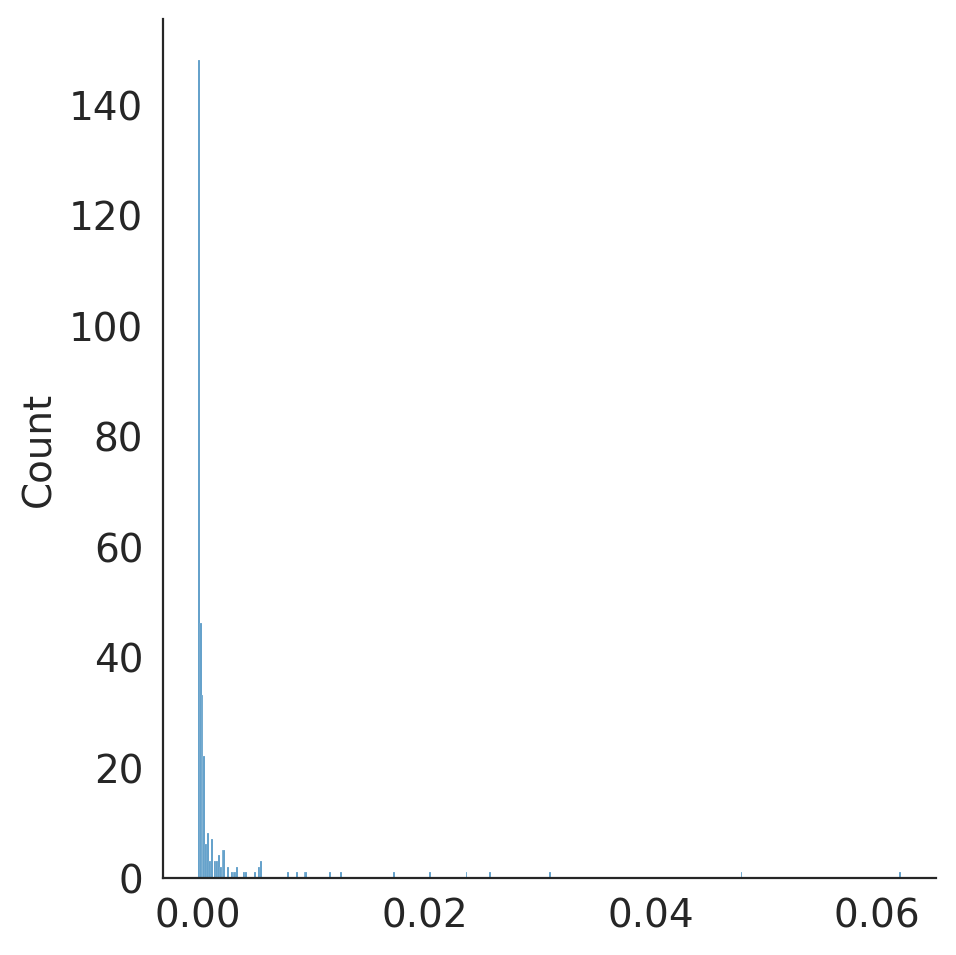

In [138]:
sns.displot(pathway_variance)

In [91]:
np.mean(pathway_variance)

0.0014253237635844563

In [92]:
# Highly variable pathways
HVPs = [idx for idx in pathway_variance[pathway_variance > np.mean(pathway_variance)].index.unique()]

In [93]:
len(HVPs)

50

In [94]:
celltypes_DxC_GSEA_HVP = celltypes_DxC_GSEA.loc[HVPs]
celltypes_DxC_GSEA_HVP.shape # some factors are assigned to the same pathway

(50, 15)

In [95]:
celltypes_DxC_KEGG_HVP = celltypes_DxC_GSEA_HVP.assign(Pathway = celltypes_DxC_GSEA_HVP.Factor.replace(DxC_pathways_dict_kegg))
celltypes_DxC_KEGG_HVP = celltypes_DxC_KEGG_HVP.loc[~celltypes_DxC_KEGG_HVP.Pathway.str.contains("DxC_Factor")]
celltypes_DxC_KEGG_HVP.shape

(30, 16)

In [96]:
celltypes_DxC_KEGG_HVP = celltypes_DxC_KEGG_HVP.assign(
    Factor_Pathway = celltypes_DxC_KEGG_HVP.Factor.str.replace("_Factor", "") + "; " + celltypes_DxC_KEGG_HVP.Pathway
)
celltypes_DxC_KEGG_HVP.set_index("Factor_Pathway", inplace=True)
celltypes_DxC_KEGG_HVP.head()

cell_label                                                 Factor      B IN  \
Factor_Pathway                                                                
DxC54; PD-L1 expression and PD-1 checkpoint pat...   DxC_Factor54 -0.034245   
DxC68; Ribosome                                      DxC_Factor68 -0.018944   
DxC141; Pathways of neurodegeneration               DxC_Factor141 -0.095661   
DxC148; Hematopoietic cell lineage                  DxC_Factor148 -0.003983   
DxC149; Colorectal cancer                           DxC_Factor149 -0.171237   

cell_label                                             B Mem    CD4 ET  \
Factor_Pathway                                                           
DxC54; PD-L1 expression and PD-1 checkpoint pat... -0.052580 -0.065050   
DxC68; Ribosome                                    -0.034055 -0.026084   
DxC141; Pathways of neurodegeneration              -0.083072 -0.051452   
DxC148; Hematopoietic cell lineage                  0.001353 -0.002234   
DxC149; Colorectal cancer                          -0.095992 -0.029960   

cell_label                                            CD4 NC  CD4 SOX4  \
Factor_Pathway                                                           
DxC54; PD-L1 expression and PD-1 checkpoint pat... -0.033378 -0.123488   
DxC68; Ribosome                                    -0.019075  0.001002   
DxC141; Pathways of neurodegeneration              -0.082297 -0.076790   
DxC148; Hematopoietic cell lineage                 -0.003066  0.005532   
DxC149; Colorectal cancer                          -0.031352 -0.038602   

cell_label                                            CD8 ET    CD8 NC  \
Factor_Pathway                                                           
DxC54; PD-L1 expression and PD-1 checkpoint pat...  0.034576 -0.067760   
DxC68; Ribosome                                    -0.025146 -0.018423   
DxC141; Pathways of neurodegeneration              -0.087611 -0.090494   
DxC148; Hematopoietic cell lineage                  0.033568  0.000732   
DxC149; Colorectal cancer                          -0.024183 -0.031224   

cell_label                                          CD8 S100B        DC  \
Factor_Pathway                                                            
DxC54; PD-L1 expression and PD-1 checkpoint pat...  -0.158428 -0.027288   
DxC68; Ribosome                                     -0.017334 -0.064895   
DxC141; Pathways of neurodegeneration               -0.063071 -0.015795   
DxC148; Hematopoietic cell lineage                   0.005430  0.000964   
DxC149; Colorectal cancer                           -0.027805 -0.054029   

cell_label                                            Mono C   Mono NC  \
Factor_Pathway                                                           
DxC54; PD-L1 expression and PD-1 checkpoint pat... -0.049498 -0.011467   
DxC68; Ribosome                                    -0.158172 -0.149158   
DxC141; Pathways of neurodegeneration               0.079120  0.455875   
DxC148; Hematopoietic cell lineage                 -0.005910 -0.011720   
DxC149; Colorectal cancer                          -0.028656 -0.066983   

cell_label                                                NK      NK R  \
Factor_Pathway                                                           
DxC54; PD-L1 expression and PD-1 checkpoint pat...  0.025670  0.159143   
DxC68; Ribosome                                    -0.031344 -0.040977   
DxC141; Pathways of neurodegeneration              -0.042217 -0.031548   
DxC148; Hematopoietic cell lineage                 -0.170632 -0.037743   
DxC149; Colorectal cancer                          -0.026628 -0.025772   

cell_label                                            Plasma  \
Factor_Pathway                                                 
DxC54; PD-L1 expression and PD-1 checkpoint pat... -0.005452   
DxC68; Ribosome                                    -0.019997   
DxC141; Pathways of neurodegeneration              -0.016936   
DxC14

In [97]:
celltypes_DxC_Reactome_HVP = celltypes_DxC_GSEA_HVP.assign(Pathway = celltypes_DxC_GSEA_HVP.Factor.replace(DxC_pathways_dict_reactome))
celltypes_DxC_Reactome_HVP = celltypes_DxC_Reactome_HVP.loc[~celltypes_DxC_Reactome_HVP.Pathway.str.contains("DxC_Factor")]
celltypes_DxC_Reactome_HVP.shape

(39, 16)

In [98]:
celltypes_DxC_Reactome_HVP = celltypes_DxC_Reactome_HVP.assign(
    Factor_Pathway = celltypes_DxC_Reactome_HVP.Factor.str.replace("_Factor", "") + "; " + celltypes_DxC_Reactome_HVP.Pathway
)
celltypes_DxC_Reactome_HVP.set_index("Factor_Pathway", inplace=True)
celltypes_DxC_Reactome_HVP.head()

cell_label                                                 Factor      B IN  \
Factor_Pathway                                                                
DxC54; Immune System R-HSA-168256                    DxC_Factor54 -0.034245   
DxC68; Cellular Responses To Stress R-HSA-2262752    DxC_Factor68 -0.018944   
DxC98; Keratinization R-HSA-6805567                  DxC_Factor98  0.068549   
DxC110; Immune System R-HSA-168256                  DxC_Factor110 -0.215186   
DxC112; Classical Antibody-Mediated Complement ...  DxC_Factor112 -0.214231   

cell_label                                             B Mem    CD4 ET  \
Factor_Pathway                                                           
DxC54; Immune System R-HSA-168256                  -0.052580 -0.065050   
DxC68; Cellular Responses To Stress R-HSA-2262752  -0.034055 -0.026084   
DxC98; Keratinization R-HSA-6805567                 0.088261  0.185029   
DxC110; Immune System R-HSA-168256                 -0.212450 -0.151049   
DxC112; Classical Antibody-Mediated Complement ... -0.181468 -0.019994   

cell_label                                            CD4 NC  CD4 SOX4  \
Factor_Pathway                                                           
DxC54; Immune System R-HSA-168256                  -0.033378 -0.123488   
DxC68; Cellular Responses To Stress R-HSA-2262752  -0.019075  0.001002   
DxC98; Keratinization R-HSA-6805567                 0.151009  0.129550   
DxC110; Immune System R-HSA-168256                 -0.149164 -0.164558   
DxC112; Classical Antibody-Mediated Complement ... -0.021639 -0.021114   

cell_label                                            CD8 ET    CD8 NC  \
Factor_Pathway                                                           
DxC54; Immune System R-HSA-168256                   0.034576 -0.067760   
DxC68; Cellular Responses To Stress R-HSA-2262752  -0.025146 -0.018423   
DxC98; Keratinization R-HSA-6805567                 0.084605  0.123543   
DxC110; Immune System R-HSA-168256                 -0.158649 -0.162243   
DxC112; Classical Antibody-Mediated Complement ... -0.020323 -0.019426   

cell_label                                          CD8 S100B        DC  \
Factor_Pathway                                                            
DxC54; Immune System R-HSA-168256                   -0.158428 -0.027288   
DxC68; Cellular Responses To Stress R-HSA-2262752   -0.017334 -0.064895   
DxC98; Keratinization R-HSA-6805567                  0.113300  0.045011   
DxC110; Immune System R-HSA-168256                  -0.167780  0.005048   
DxC112; Classical Antibody-Mediated Complement ...  -0.015391 -0.045626   

cell_label                                            Mono C   Mono NC  \
Factor_Pathway                                                           
DxC54; Immune System R-HSA-168256                  -0.049498 -0.011467   
DxC68; Cellular Responses To Stress R-HSA-2262752  -0.158172 -0.149158   
DxC98; Keratinization R-HSA-6805567                 0.055235  0.227816   
DxC110; Immune System R-HSA-168256                 -0.048969 -0.035276   
DxC112; Classical Antibody-Mediated Complement ... -0.013490 -0.013429   

cell_label                                                NK      NK R  \
Factor_Pathway                                                           
DxC54; Immune System R-HSA-168256                   0.025670  0.159143   
DxC68; Cellular Responses To Stress R-HSA-2262752  -0.031344 -0.040977   
DxC98; Keratinization R-HSA-6805567                 0.067140  0.059125   
DxC110; Immune System R-HSA-168256                 -0.144006 -0.303715   
DxC112; Classical Antibody-Mediated Complement ... -0.018709 -0.025693   

cell_label                                            Plasma  \
Factor_Pathway                                                 
DxC54; Immune System R-HSA-168256                  -0.005452   
DxC68; Cellular Responses To Stress R-HSA-2262752  -0.019997   
DxC98; Keratinization R-HSA-6805567                 0.023831   
DxC11

In [99]:
celltypes_DxC_GOBio_HVP = celltypes_DxC_GSEA_HVP.assign(Pathway = celltypes_DxC_GSEA_HVP.Factor.replace(DxC_pathways_dict_GOBio))
celltypes_DxC_GOBio_HVP = celltypes_DxC_GOBio_HVP.loc[~celltypes_DxC_GOBio_HVP.Pathway.str.contains("DxC_Factor")]
celltypes_DxC_GOBio_HVP.shape

(47, 16)

In [100]:
celltypes_DxC_GOBio_HVP = celltypes_DxC_GOBio_HVP.assign(
    Factor_Pathway = celltypes_DxC_GOBio_HVP.Factor.str.replace("_Factor", "") + "; " + celltypes_DxC_GOBio_HVP.Pathway
)
celltypes_DxC_GOBio_HVP.set_index("Factor_Pathway", inplace=True)
celltypes_DxC_GOBio_HVP.head()

cell_label                                                 Factor      B IN  \
Factor_Pathway                                                                
DxC54; Response To Type II Interferon (GO:0034341)   DxC_Factor54 -0.034245   
DxC68; Cytoplasmic Translation (GO:0002181)          DxC_Factor68 -0.018944   
DxC98; Complement Activation, Lectin Pathway (G...   DxC_Factor98  0.068549   
DxC110; Cellular Response To Cytokine Stimulus ...  DxC_Factor110 -0.215186   
DxC132; Negative Regulation Of Phospholipase Ac...  DxC_Factor132  0.498165   

cell_label                                             B Mem    CD4 ET  \
Factor_Pathway                                                           
DxC54; Response To Type II Interferon (GO:0034341) -0.052580 -0.065050   
DxC68; Cytoplasmic Translation (GO:0002181)        -0.034055 -0.026084   
DxC98; Complement Activation, Lectin Pathway (G...  0.088261  0.185029   
DxC110; Cellular Response To Cytokine Stimulus ... -0.212450 -0.151049   
DxC132; Negative Regulation Of Phospholipase Ac... -0.240417  0.000774   

cell_label                                            CD4 NC  CD4 SOX4  \
Factor_Pathway                                                           
DxC54; Response To Type II Interferon (GO:0034341) -0.033378 -0.123488   
DxC68; Cytoplasmic Translation (GO:0002181)        -0.019075  0.001002   
DxC98; Complement Activation, Lectin Pathway (G...  0.151009  0.129550   
DxC110; Cellular Response To Cytokine Stimulus ... -0.149164 -0.164558   
DxC132; Negative Regulation Of Phospholipase Ac...  0.012159 -0.002691   

cell_label                                            CD8 ET    CD8 NC  \
Factor_Pathway                                                           
DxC54; Response To Type II Interferon (GO:0034341)  0.034576 -0.067760   
DxC68; Cytoplasmic Translation (GO:0002181)        -0.025146 -0.018423   
DxC98; Complement Activation, Lectin Pathway (G...  0.084605  0.123543   
DxC110; Cellular Response To Cytokine Stimulus ... -0.158649 -0.162243   
DxC132; Negative Regulation Of Phospholipase Ac... -0.019481 -0.000809   

cell_label                                          CD8 S100B        DC  \
Factor_Pathway                                                            
DxC54; Response To Type II Interferon (GO:0034341)  -0.158428 -0.027288   
DxC68; Cytoplasmic Translation (GO:0002181)         -0.017334 -0.064895   
DxC98; Complement Activation, Lectin Pathway (G...   0.113300  0.045011   
DxC110; Cellular Response To Cytokine Stimulus ...  -0.167780  0.005048   
DxC132; Negative Regulation Of Phospholipase Ac...  -0.006543 -0.046817   

cell_label                                            Mono C   Mono NC  \
Factor_Pathway                                                           
DxC54; Response To Type II Interferon (GO:0034341) -0.049498 -0.011467   
DxC68; Cytoplasmic Translation (GO:0002181)        -0.158172 -0.149158   
DxC98; Complement Activation, Lectin Pathway (G...  0.055235  0.227816   
DxC110; Cellular Response To Cytokine Stimulus ... -0.048969 -0.035276   
DxC132; Negative Regulation Of Phospholipase Ac... -0.024407 -0.020750   

cell_label                                                NK      NK R  \
Factor_Pathway                                                           
DxC54; Response To Type II Interferon (GO:0034341)  0.025670  0.159143   
DxC68; Cytoplasmic Translation (GO:0002181)        -0.031344 -0.040977   
DxC98; Complement Activation, Lectin Pathway (G...  0.067140  0.059125   
DxC110; Cellular Response To Cytokine Stimulus ... -0.144006 -0.303715   
DxC132; Negative Regulation Of Phospholipase Ac... -0.002390 -0.003917   

cell_label                                            Plasma  \
Factor_Pathway                                                 
DxC54; Response To Type II Interferon (GO:0034341) -0.005452   
DxC68; Cytoplasmic Translation (GO:0002181)        -0.019997   
DxC98; Complement Activation, Lectin Pathway (G...  0.023831   
DxC11

In [101]:
celltypes_DxC_GOMF_HVP = celltypes_DxC_GSEA_HVP.assign(Pathway = celltypes_DxC_GSEA_HVP.Factor.replace(DxC_pathways_dict_GOMF))
celltypes_DxC_GOMF_HVP = celltypes_DxC_GOMF_HVP.loc[~celltypes_DxC_GOMF_HVP.Pathway.str.contains("DxC_Factor")]
celltypes_DxC_GOMF_HVP.shape

(36, 16)

In [102]:
celltypes_DxC_GOMF_HVP = celltypes_DxC_GOMF_HVP.assign(
    Factor_Pathway = celltypes_DxC_GOMF_HVP.Factor.str.replace("_Factor", "") + "; " + celltypes_DxC_GOMF_HVP.Pathway
)
celltypes_DxC_GOMF_HVP.set_index("Factor_Pathway", inplace=True)
celltypes_DxC_GOMF_HVP.head()

cell_label                                                 Factor      B IN  \
Factor_Pathway                                                                
DxC68; RNA Binding (GO:0003723)                      DxC_Factor68 -0.018944   
DxC98; Protein Heterodimerization Activity (GO:...   DxC_Factor98  0.068549   
DxC141; Active Monoatomic Ion Transmembrane Tra...  DxC_Factor141 -0.095661   
DxC148; Signaling Receptor Complex Adaptor Acti...  DxC_Factor148 -0.003983   
DxC149; Protein Serine/Threonine Kinase Inhibit...  DxC_Factor149 -0.171237   

cell_label                                             B Mem    CD4 ET  \
Factor_Pathway                                                           
DxC68; RNA Binding (GO:0003723)                    -0.034055 -0.026084   
DxC98; Protein Heterodimerization Activity (GO:...  0.088261  0.185029   
DxC141; Active Monoatomic Ion Transmembrane Tra... -0.083072 -0.051452   
DxC148; Signaling Receptor Complex Adaptor Acti...  0.001353 -0.002234   
DxC149; Protein Serine/Threonine Kinase Inhibit... -0.095992 -0.029960   

cell_label                                            CD4 NC  CD4 SOX4  \
Factor_Pathway                                                           
DxC68; RNA Binding (GO:0003723)                    -0.019075  0.001002   
DxC98; Protein Heterodimerization Activity (GO:...  0.151009  0.129550   
DxC141; Active Monoatomic Ion Transmembrane Tra... -0.082297 -0.076790   
DxC148; Signaling Receptor Complex Adaptor Acti... -0.003066  0.005532   
DxC149; Protein Serine/Threonine Kinase Inhibit... -0.031352 -0.038602   

cell_label                                            CD8 ET    CD8 NC  \
Factor_Pathway                                                           
DxC68; RNA Binding (GO:0003723)                    -0.025146 -0.018423   
DxC98; Protein Heterodimerization Activity (GO:...  0.084605  0.123543   
DxC141; Active Monoatomic Ion Transmembrane Tra... -0.087611 -0.090494   
DxC148; Signaling Receptor Complex Adaptor Acti...  0.033568  0.000732   
DxC149; Protein Serine/Threonine Kinase Inhibit... -0.024183 -0.031224   

cell_label                                          CD8 S100B        DC  \
Factor_Pathway                                                            
DxC68; RNA Binding (GO:0003723)                     -0.017334 -0.064895   
DxC98; Protein Heterodimerization Activity (GO:...   0.113300  0.045011   
DxC141; Active Monoatomic Ion Transmembrane Tra...  -0.063071 -0.015795   
DxC148; Signaling Receptor Complex Adaptor Acti...   0.005430  0.000964   
DxC149; Protein Serine/Threonine Kinase Inhibit...  -0.027805 -0.054029   

cell_label                                            Mono C   Mono NC  \
Factor_Pathway                                                           
DxC68; RNA Binding (GO:0003723)                    -0.158172 -0.149158   
DxC98; Protein Heterodimerization Activity (GO:...  0.055235  0.227816   
DxC141; Active Monoatomic Ion Transmembrane Tra...  0.079120  0.455875   
DxC148; Signaling Receptor Complex Adaptor Acti... -0.005910 -0.011720   
DxC149; Protein Serine/Threonine Kinase Inhibit... -0.028656 -0.066983   

cell_label                                                NK      NK R  \
Factor_Pathway                                                           
DxC68; RNA Binding (GO:0003723)                    -0.031344 -0.040977   
DxC98; Protein Heterodimerization Activity (GO:...  0.067140  0.059125   
DxC141; Active Monoatomic Ion Transmembrane Tra... -0.042217 -0.031548   
DxC148; Signaling Receptor Complex Adaptor Acti... -0.170632 -0.037743   
DxC149; Protein Serine/Threonine Kinase Inhibit... -0.026628 -0.025772   

cell_label                                            Plasma  \
Factor_Pathway                                                 
DxC68; RNA Binding (GO:0003723)                    -0.019997   
DxC98; Protein Heterodimerization Activity (GO:...  0.023831   
DxC141; Active Monoatomic Ion Transmembrane Tra... -0.016936   
DxC14

### Heatmaps

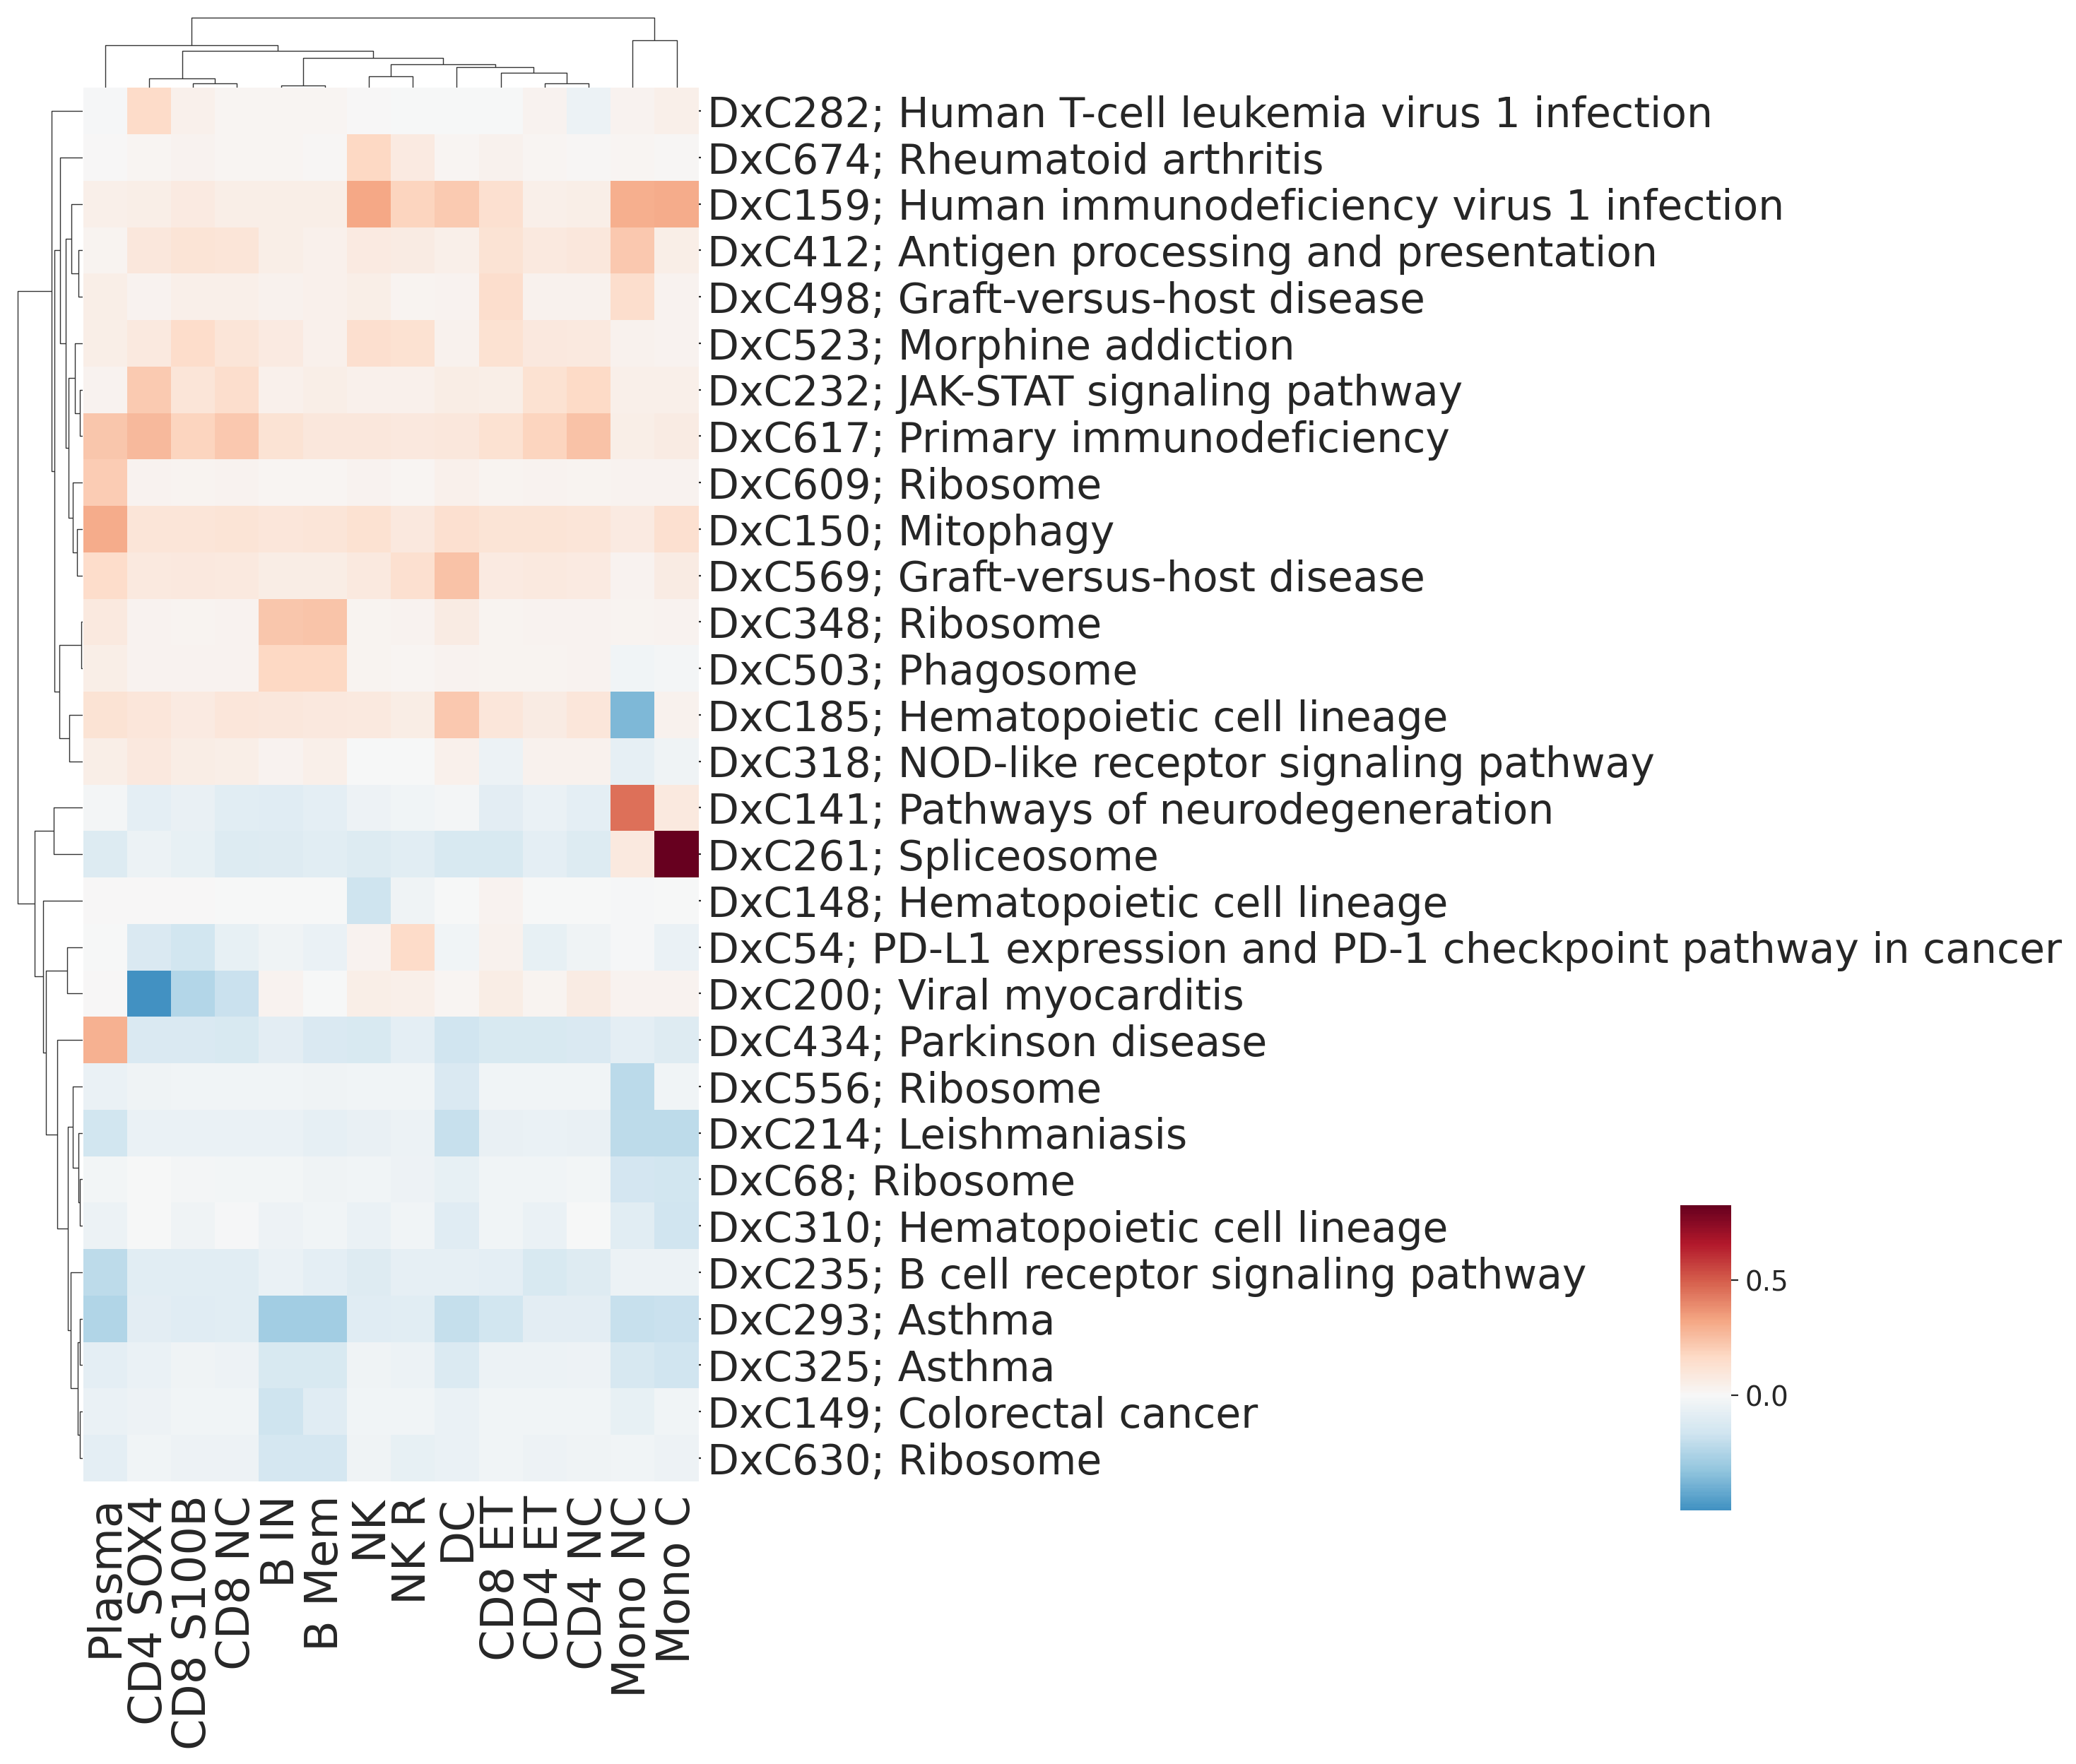

In [170]:
clm = sns.clustermap(
    celltypes_DxC_KEGG_HVP.filter(adata.obs.cell_label.unique()),
    figsize=(12, 12),
    col_cluster=True,
    row_cluster=True,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(1, 0.1, 0.03, 0.18), # x, y, width, height
    metric="cosine",
    cmap="RdBu_r",
    center=0,
    rasterized=True,
    yticklabels=True,
)

clm.ax_heatmap.set_yticklabels(clm.ax_heatmap.get_yticklabels(), fontsize=21)
clm.ax_heatmap.set_ylabel("")
clm.ax_heatmap.tick_params(axis='y', length=1)

clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_xticklabels(
    clm.ax_heatmap.get_xticklabels(),
    fontsize=23
)

# clm.fig.suptitle("$U$ factors clustering based on cell type assignments", fontsize=16, y=0.8)

clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_KEGG-highly-variable-pathways_TopGenes-100-IQR.png"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)

clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_KEGG-highly-variable-pathways_TopGenes-100-IQR.pdf"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)
clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_KEGG-highly-variable-pathways_TopGenes-100-IQR.eps"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)

In [163]:
# Wrap text for plotting
celltypes_DxC_Reactome_HVP.index = celltypes_DxC_Reactome_HVP.index.map(lambda idx: textwrap.fill(idx, width=70))

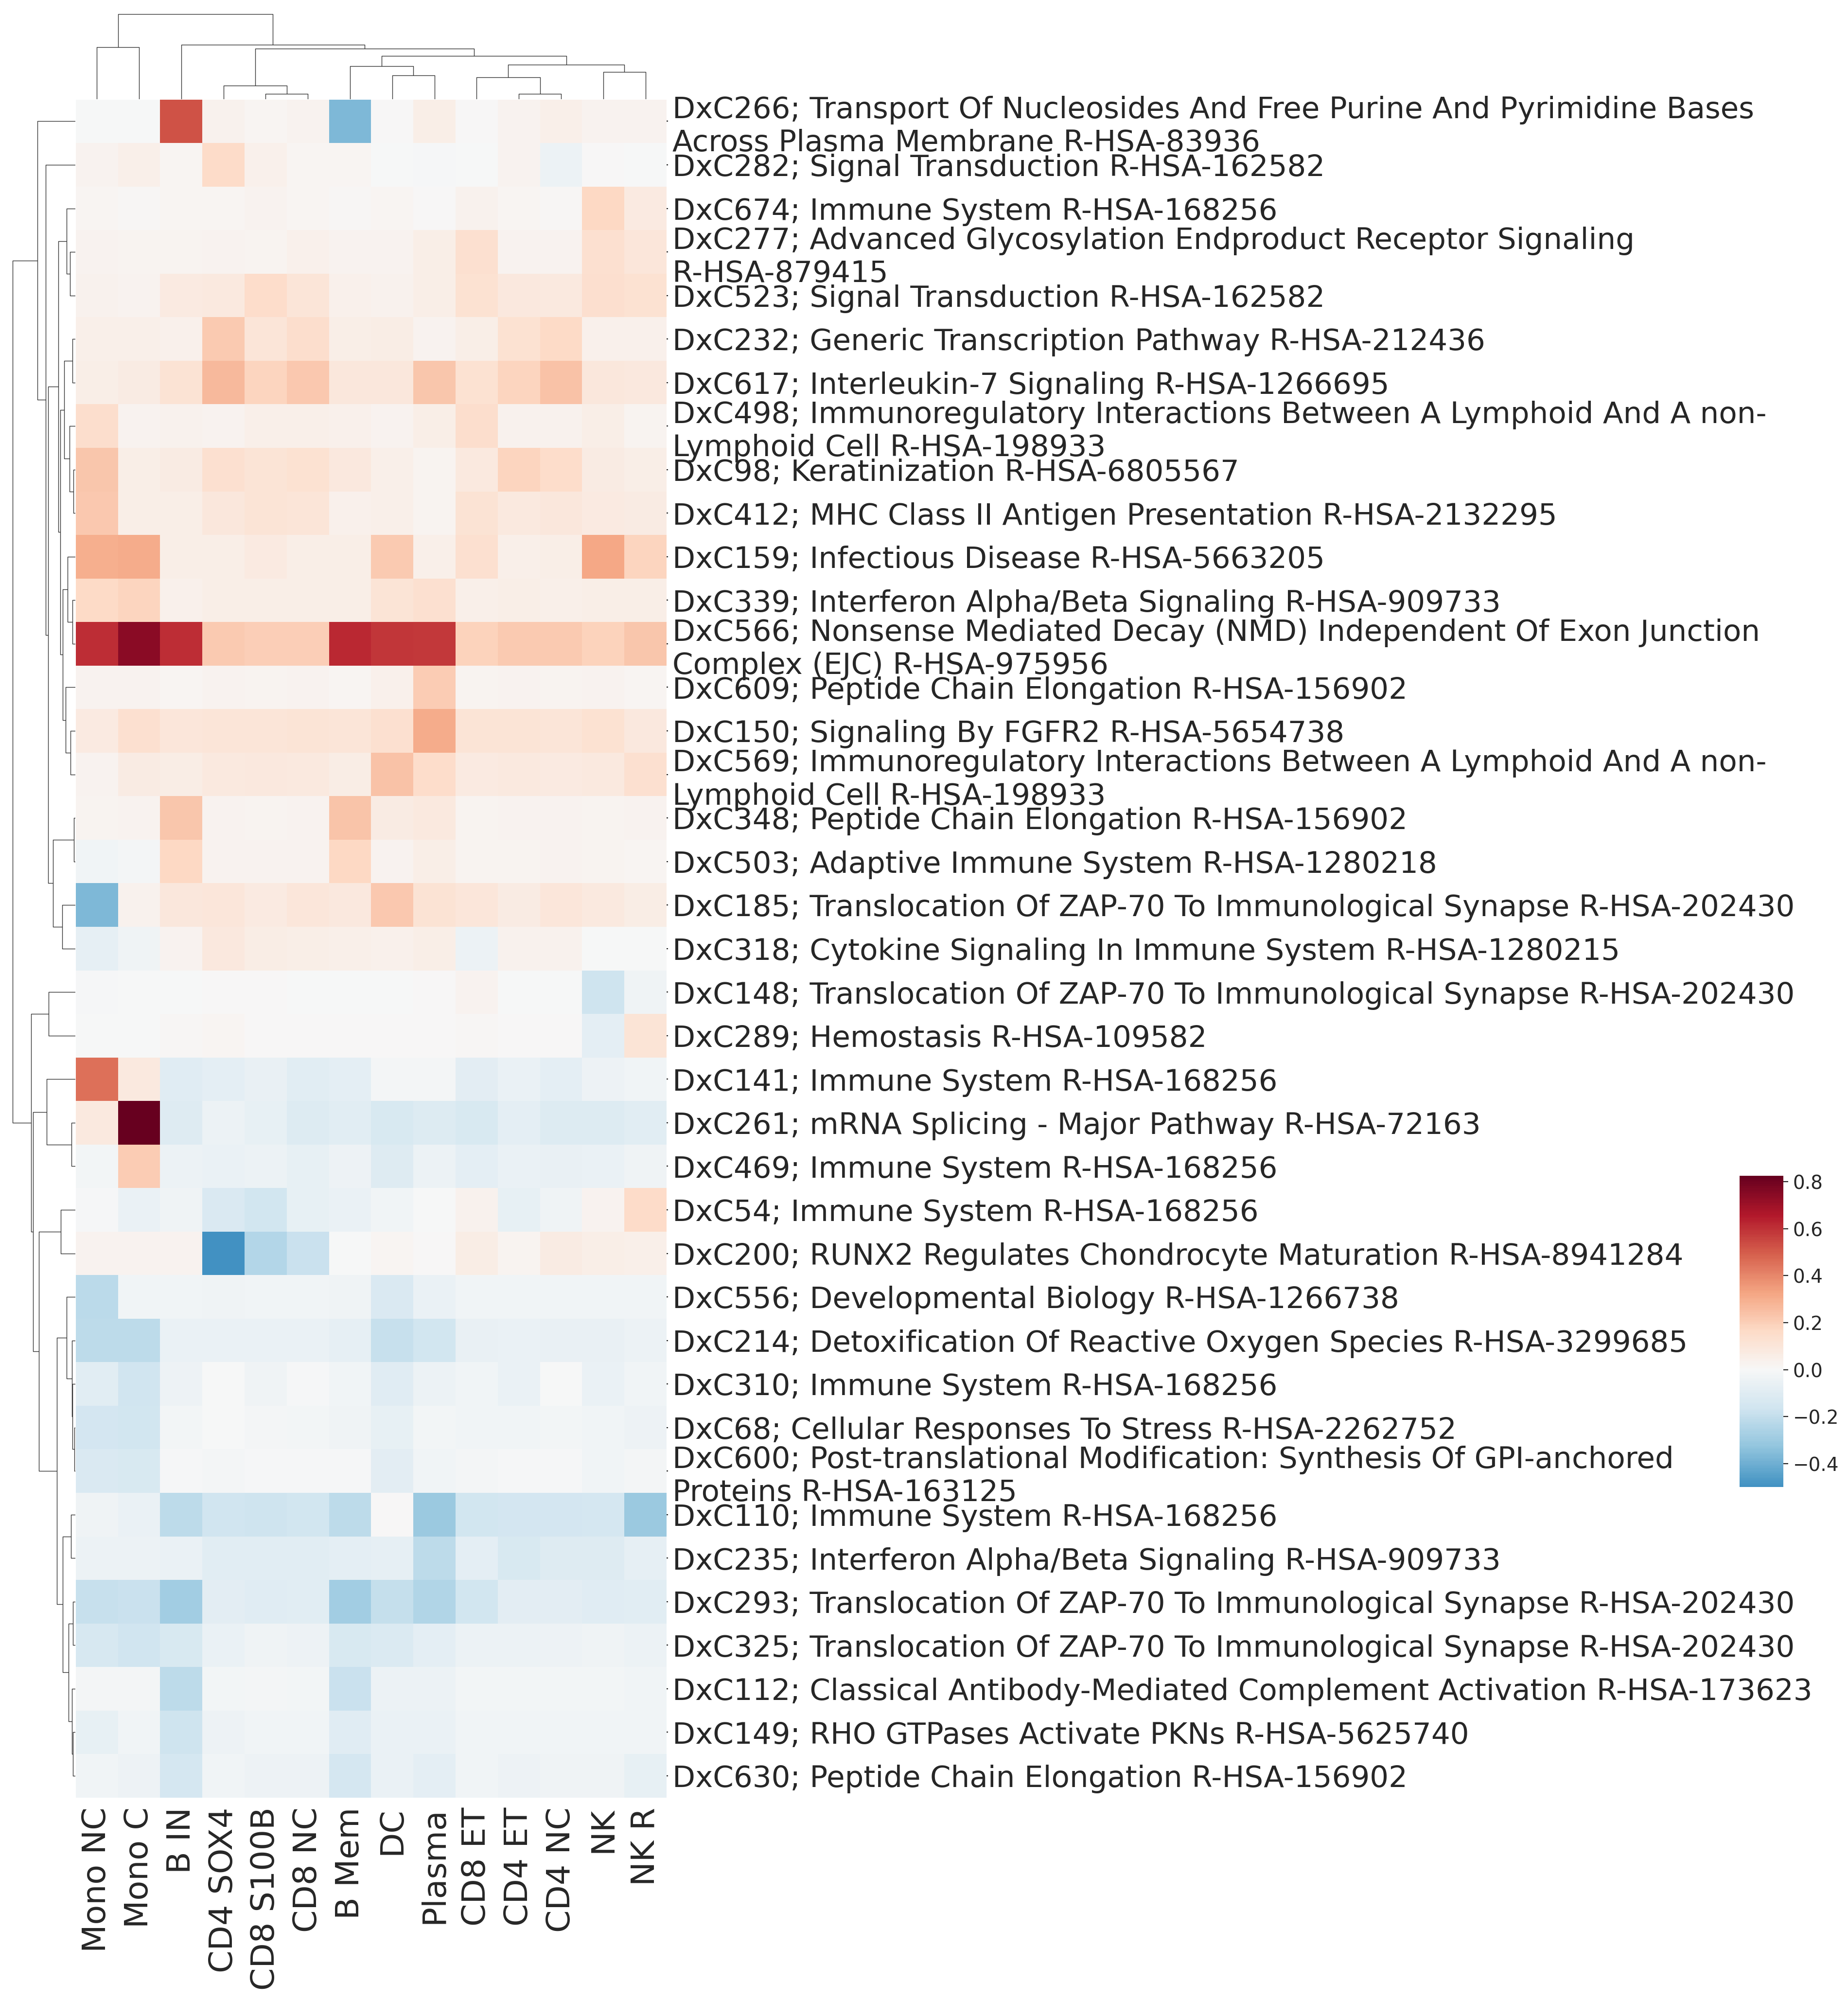

In [169]:
clm = sns.clustermap(
    celltypes_DxC_Reactome_HVP.filter(adata.obs.cell_label.unique()),
    figsize=(15, 20),  # x, y,
    col_cluster=True,
    row_cluster=True,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(1.2, 0.23, 0.03, 0.16), # x, y, width, height
    metric="cosine",
    cmap="RdBu_r",
    center=0,
    rasterized=True,
    yticklabels=True,
)

clm.ax_heatmap.set_yticklabels(clm.ax_heatmap.get_yticklabels(), fontsize=22)
clm.ax_heatmap.set_ylabel("")
clm.ax_heatmap.tick_params(axis='y', length=1)

clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_xticklabels(
    clm.ax_heatmap.get_xticklabels(),
    fontsize=24
)

# clm.fig.suptitle("$U$ factors clustering based on cell type assignments", fontsize=16, y=0.8)

clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_Reactome-highly-variable-pathways_TopGenes-100-IQR.png"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)

clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_Reactome-highly-variable-pathways_TopGenes-100-IQR.pdf"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)
clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_Reactome-highly-variable-pathways_TopGenes-100-IQR.eps"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)

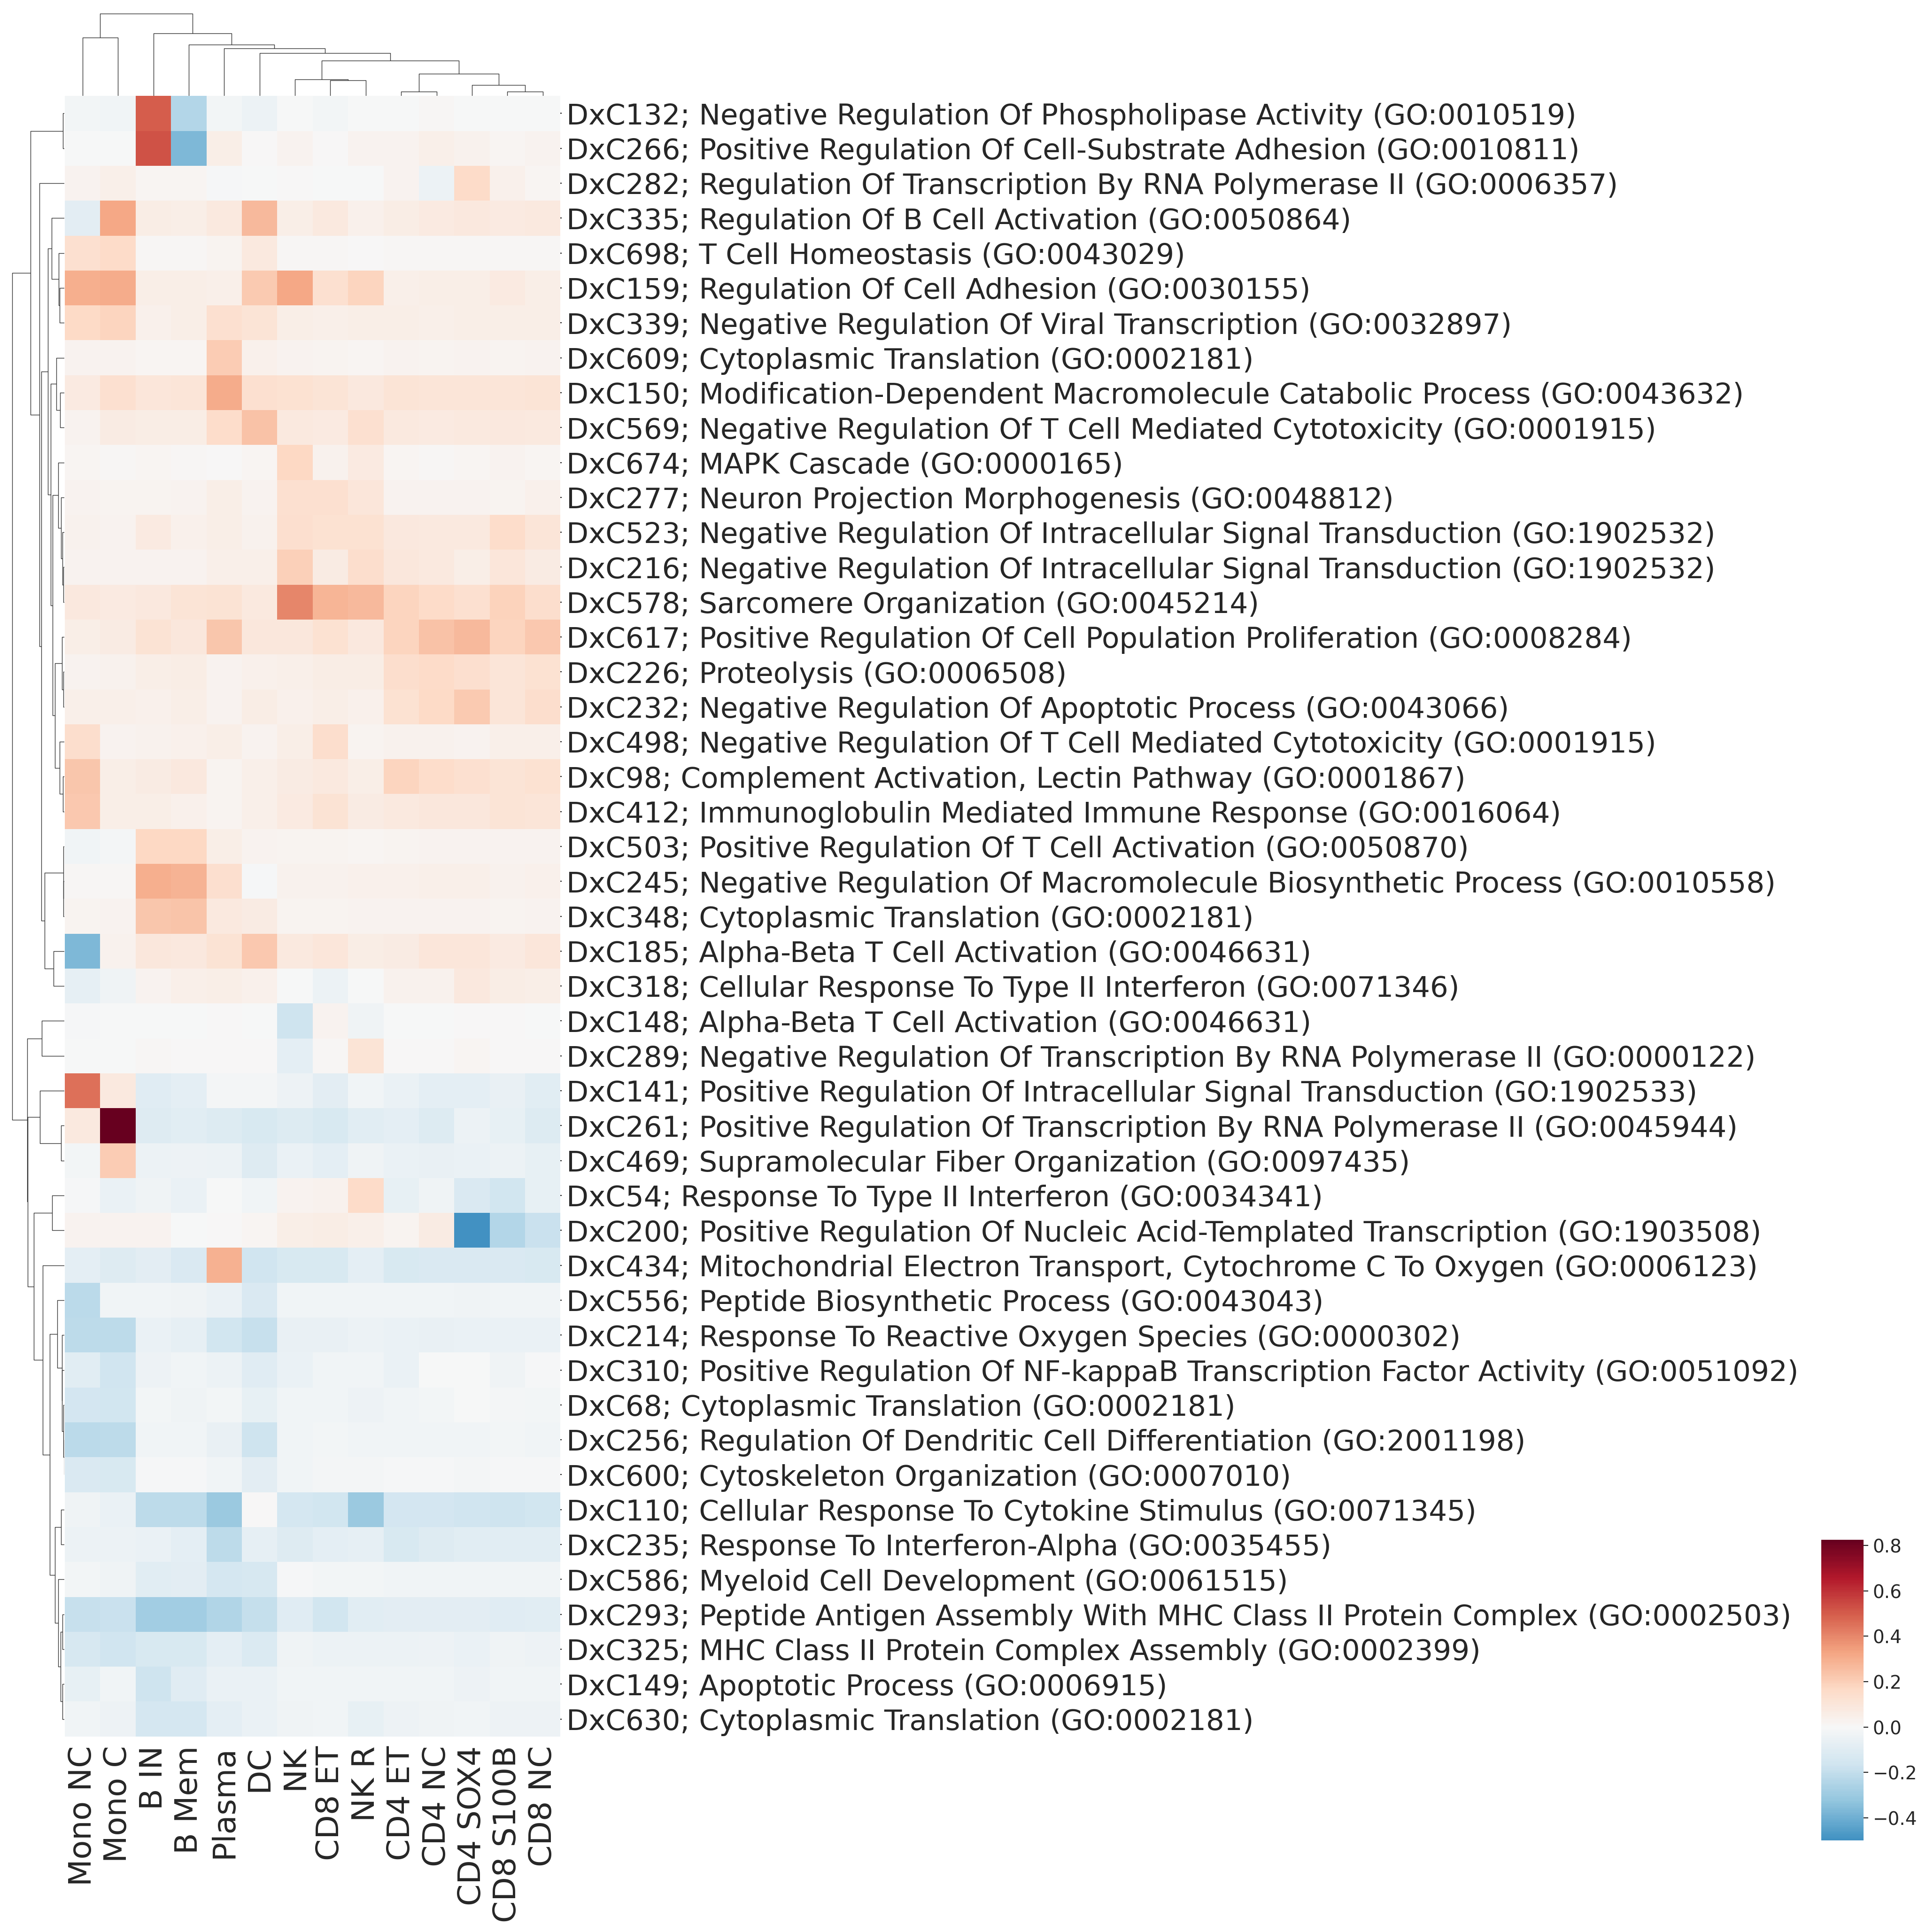

In [168]:
clm = sns.clustermap(
    celltypes_DxC_GOBio_HVP.filter(adata.obs.cell_label.unique()),
    figsize=(15, 20),
    col_cluster=True,
    row_cluster=True,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(1.3, 0.015, 0.03, 0.16), # x, y, width, height
    metric="cosine",
    cmap="RdBu_r",
    center=0,
    rasterized=True,
    yticklabels=True,
)

clm.ax_heatmap.set_yticklabels(clm.ax_heatmap.get_yticklabels(), fontsize=22)
clm.ax_heatmap.set_ylabel("")
clm.ax_heatmap.tick_params(axis='y', length=1)

clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_xticklabels(
    clm.ax_heatmap.get_xticklabels(),
    fontsize=24
)

# clm.fig.suptitle("$U$ factors clustering based on cell type assignments", fontsize=16, y=0.8)

clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_GOBio-highly-variable-pathways_TopGenes-100-IQR.png"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)

clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_GOBio-highly-variable-pathways_TopGenes-100-IQR.pdf"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)
clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_GOBio-highly-variable-pathways_TopGenes-100-IQR.eps"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)

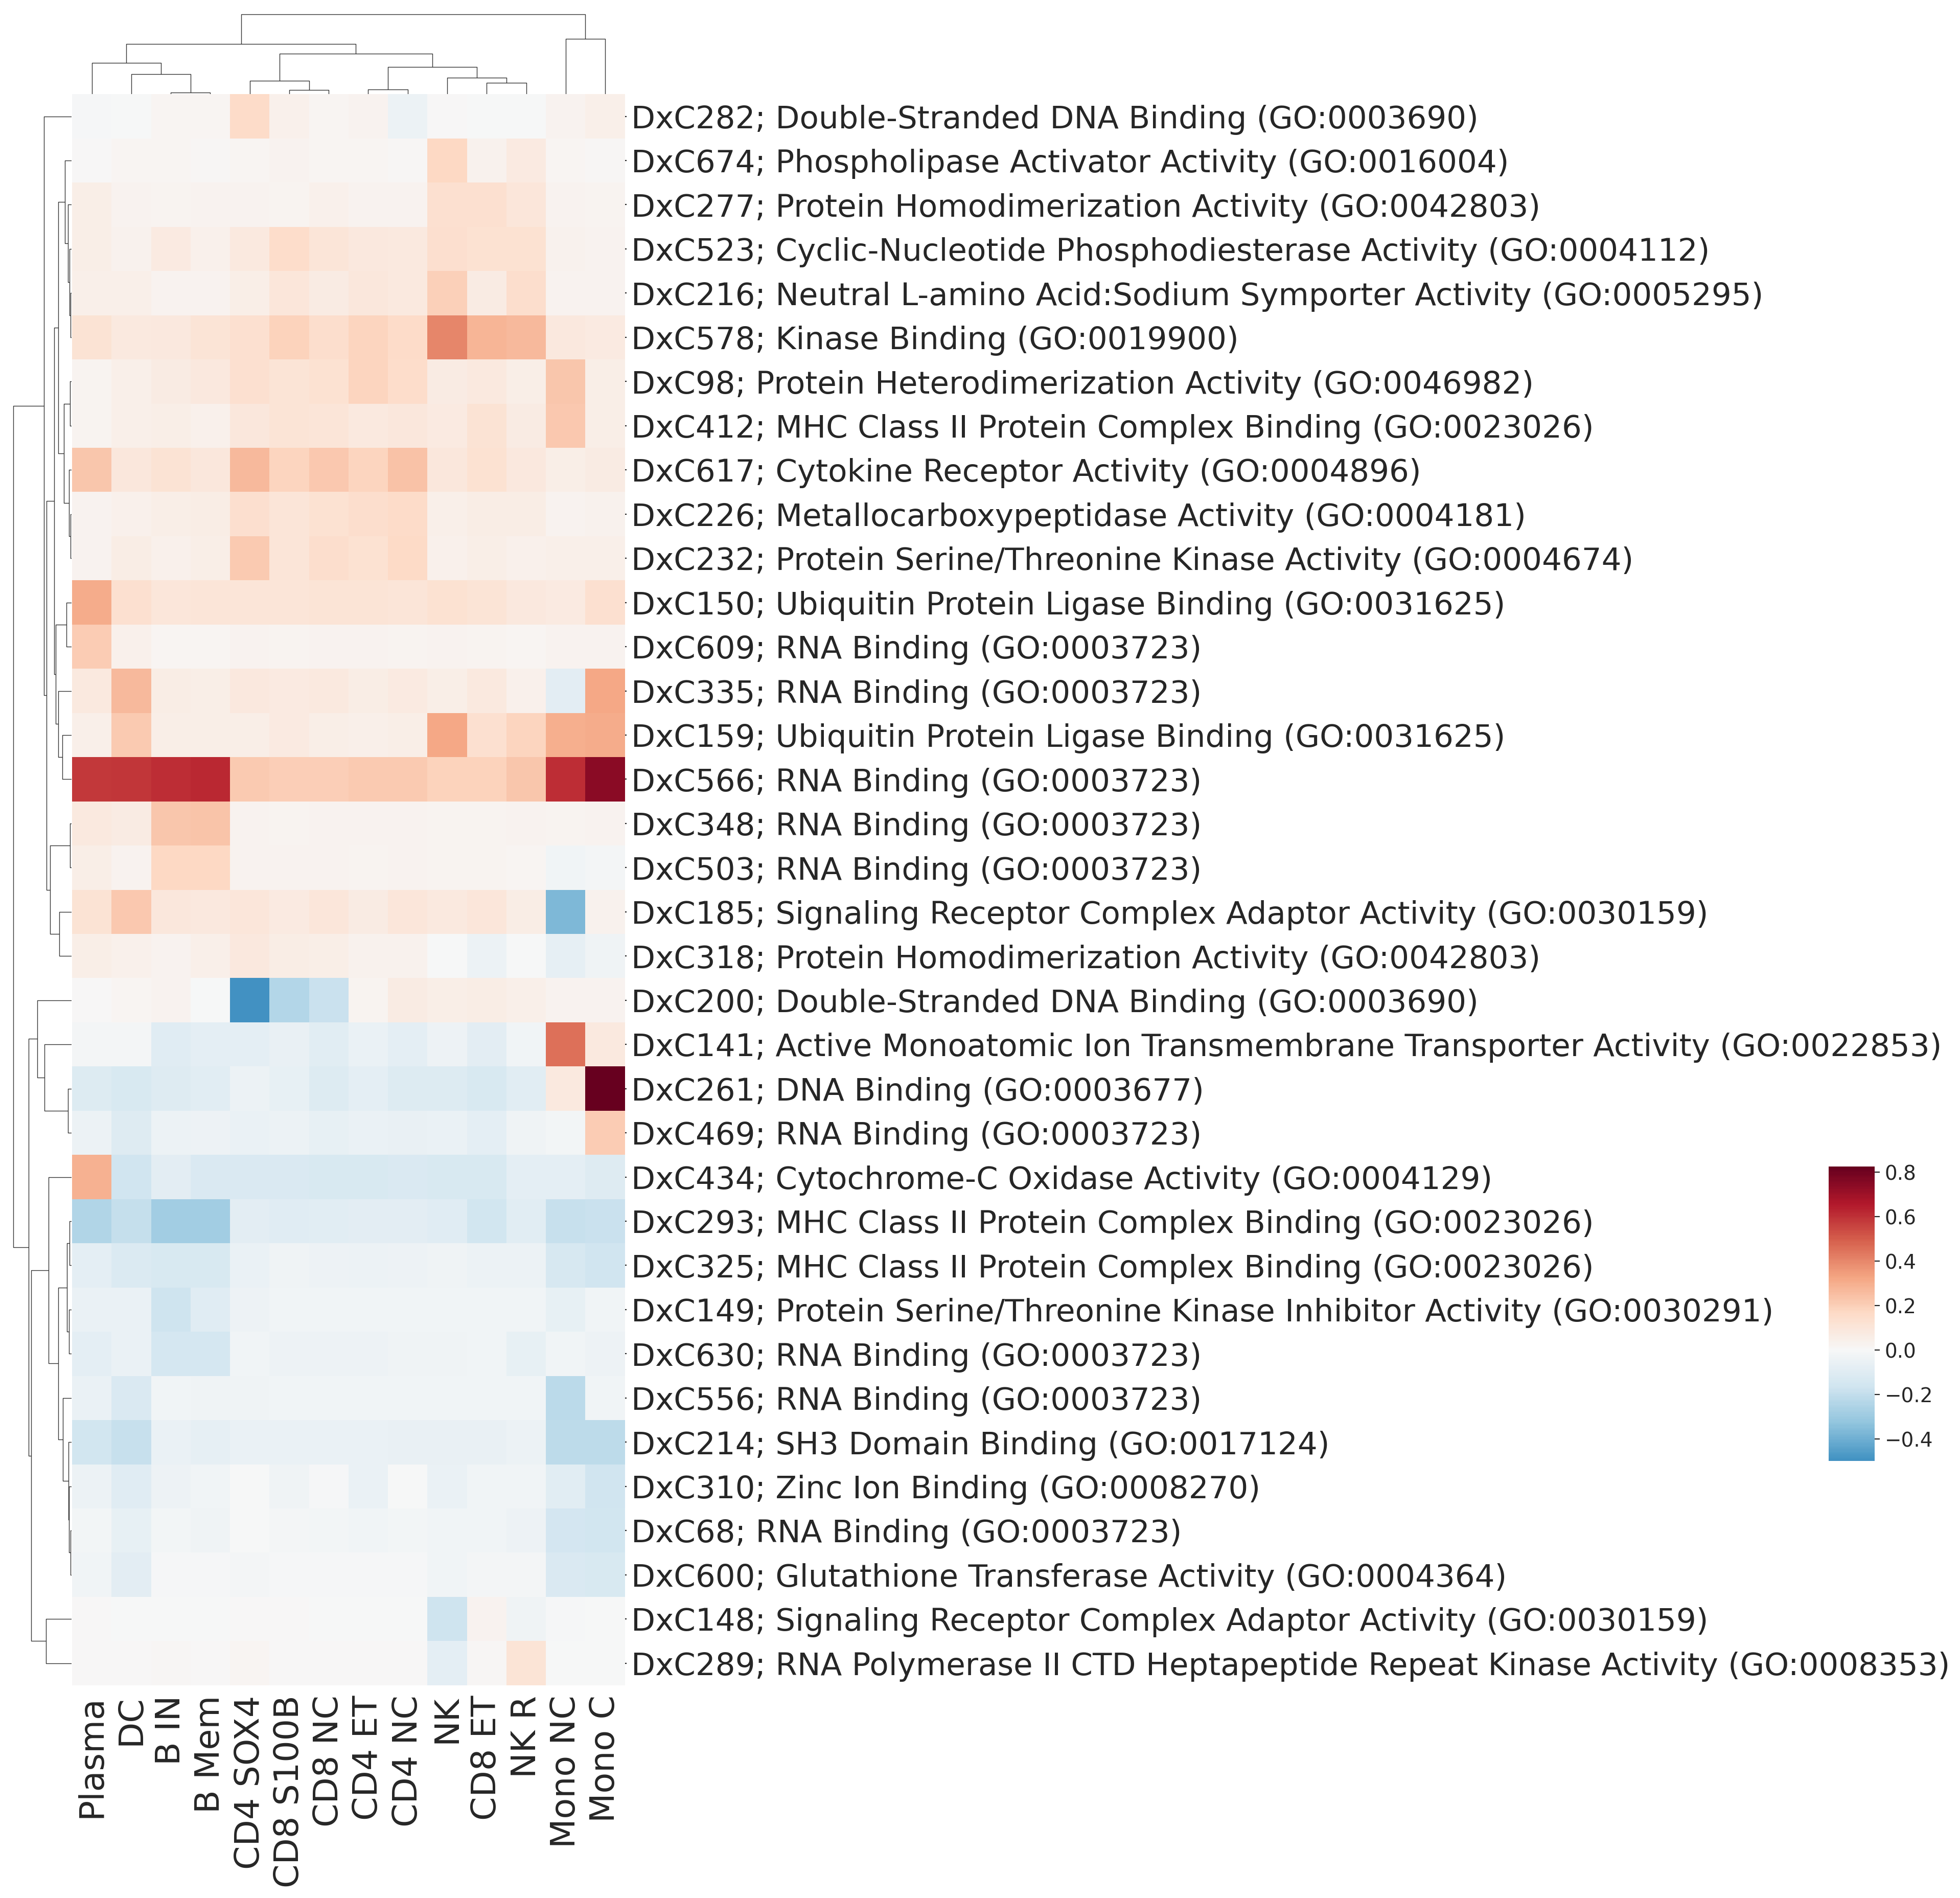

In [167]:
clm = sns.clustermap(
    celltypes_DxC_GOMF_HVP.filter(adata.obs.cell_label.unique()),
    figsize=(15, 18),
    col_cluster=True,
    row_cluster=True,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(1.2, 0.2, 0.03, 0.16), # x, y, width, height
    metric="cosine",
    cmap="RdBu_r",
    center=0,
    rasterized=True,
    yticklabels=True,
)

clm.ax_heatmap.set_yticklabels(clm.ax_heatmap.get_yticklabels(), fontsize=22)
clm.ax_heatmap.set_ylabel("")
clm.ax_heatmap.tick_params(axis='y', length=1)

clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_xticklabels(
    clm.ax_heatmap.get_xticklabels(),
    fontsize=24
)

# clm.fig.suptitle("$U$ factors clustering based on cell type assignments", fontsize=16, y=0.8)

clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_GOMF-highly-variable-pathways_TopGenes-100-IQR.png"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)

clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_GOMF-highly-variable-pathways_TopGenes-100-IQR.pdf"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)
clm.savefig(
    os.path.join(model_results_dir, "Figures", "significant-D-factor_cosine_clustering_based_on_celltypes_GOMF-highly-variable-pathways_TopGenes-100-IQR.eps"),
    dpi=700,
    transparent=True,
    bbox_inches="tight",
)